### Since I'm using the results from Task3 for Task2, so I'm doing Task3 first and then Task2.

In [517]:
import numpy as np
import pandas as pd

import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.metrics import r2_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import class_weight

## 1. Data preprocessing

In [518]:
# Import the data frame
df = pd.read_csv('cars_10_16_23.csv')
print(df.shape)
df.head()

(11304, 42)


,Unnamed: 0,Represented Test Veh Make,Aftertreatment Device Desc,Transmission Overdrive Desc,Equivalent Test Weight (lbs.),Represented Test Veh Model,Drive System Description,Test Veh Displacement (L),Shift Indicator Light Use Desc,N/V Ratio,Rated Horsepower,Test Veh Configuration #,# of Cylinders and Rotors,Target Coef B (lbf/mph),Target Coef A (lbf),Test Number,CO (g/mi),Test Category,Aftertreatment Device Cd,THC (g/mi),CH4 (g/mi),Test Fuel Type Cd,Model Year,FE_UNIT,Set Coef C (lbf/mph**2),Police - Emergency Vehicle?,Axle Ratio,Test Procedure Description,Test Fuel Type Description,Tested Transmission Type,# of Gears,Set Coef A (lbf),Test Vehicle ID,NOx (g/mi),RND_ADJ_FE,CO2 (g/mi),Tested Transmission Type Code,PM (g/mi),Vehicle Type,Set Coef B (lbf/mph),N2O (g/mi),Target Coef C (lbf/mph**2)
0,0,Aston Martin,Three-way catalyst,Top gear ratio < 1,4500,DB11 V8,"2-Wheel Drive, Rear",4.0,Not eqipped,22.2,503,0,8.0,0.0169,40.94,JASX10050824,0.0700,FTP,TWC,0.0265,0.0054,61,2023,MPG,0.0251,N,2.70,Federal fuel 2-day exhaust (w/can load),Tier 2 Cert Gasoline,Semi-Automatic,8,11.26,562TT5348,0.0290,22.7,386.66,SA,NaN,Car,0.0919,0.0064,0.0271
1,1,Aston Martin,Three-way catalyst,Top gear ratio < 1,4500,DB11 V8,"2-Wheel Drive, Rear",4.0,Not eqipped,22.2,503,0,8.0,0.0169,40.94,JASX10050825,0.0300,HWY,TWC,0.0005,NaN,61,2023,MPG,0.0251,N,2.70,HWFE,Tier 2 Cert Gasoline,Semi-Automatic,8,11.26,562TT5348,0.0020,33.8,259.74,SA,NaN,Car,0.0919,NaN,0.0271
2,2,Aston Martin,Three-way catalyst,Top gear ratio < 1,4500,DBS,"2-Wheel Drive, Rear",5.2,Not eqipped,23.0,715,0,12.0,0.0169,40.94,KASX10055440,0.9848,FTP,TWC,0.0422,0.0109,61,2023,MPG,0.0245,N,2.93,Federal fuel 2-day exhaust (w/can load),Tier 2 Cert Gasoline,Semi-Automatic,8,6.81,7002PT7056,0.0262,17.7,499.69,SA,NaN,Car,0.0807,0.0000,0.0271
3,3,Aston Martin,Three-way catalyst,Top gear ratio < 1,4500,DBS,"2-Wheel Drive, Rear",5.2,Not eqipped,23.0,715,0,12.0,0.0169,40.94,KASX10055442,0.0425,HWY,TWC,0.0000,NaN,61,2023,MPG,0.0245,N,2.93,HWFE,Tier 2 Cert Gasoline,Semi-Automatic,8,6.81,7002PT7056,0.0070,30.6,290.25,SA,NaN,Car,0.0807,NaN,0.0271
4,4,Aston Martin,Three-way catalyst,Top gear ratio < 1,5500,DBX,4-Wheel Drive,4.0,Not eqipped,21.0,550,1,8.0,-0.3286,60.68,MASX10071301,0.1200,FTP,TWC,0.0146,0.0028,61,2023,MPG,0.0367,N,3.06,Federal fuel 2-day exhaust (w/can load),Tier 2 Cert Gasoline,Automatic,9,-4.88,8001PT8342,0.0090,17.2,521.26,A,NaN,Both,-0.5318,NaN,0.0373


In [519]:
# Remove all vehicles with mpg > 120
df = df[df['RND_ADJ_FE'] <= 120]
df.shape

(11053, 42)

### 1.1 Missing data analysis

<AxesSubplot:>

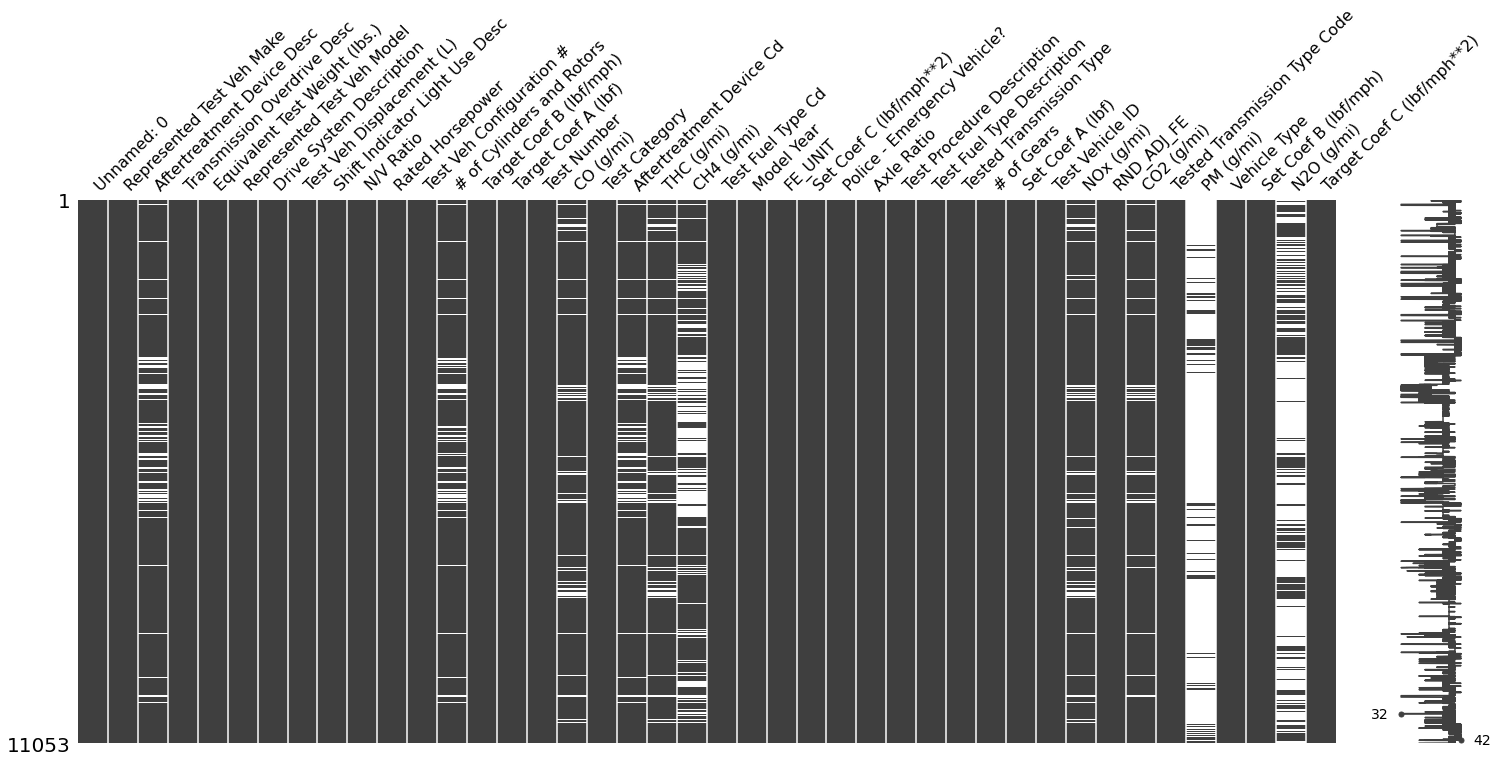

In [520]:
import missingno as msno
msno.matrix(df)

    We can see from the above chart that several columns have missing data and some columns have a high ration of missing data. Now let's find the columns that have missing data and list the missing proportion.

#### Since we're taking CO and CO2 as responses, we need to drop rows where CO and CO2 have missing values.

In [521]:
df.dropna(subset=['CO (g/mi)', 'CO2 (g/mi)'], inplace=True)
df.shape

(10064, 42)

#### Find colums that have missing values and the proportion of the missing values

In [522]:
# list all the columns and number of missing values in that column
missing_cols = df.isna().sum().reset_index()
missing_cols.columns = ["feature", "number_missing"]

# filter and exclude columns that do not have a missing value
missing_cols = missing_cols[missing_cols['number_missing'] > 0]

# compute the percentage of missing values as "missing_percentage(%)"
missing_cols['missing_percentage(%)'] = missing_cols['number_missing'] / 10064 * 100
missing_cols

,feature,number_missing,missing_percentage(%)
2,Aftertreatment Device Desc,869,8.634738
12,# of Cylinders and Rotors,762,7.571542
18,Aftertreatment Device Cd,869,8.634738
19,THC (g/mi),2,0.019873
20,CH4 (g/mi),3026,30.067568
33,NOx (g/mi),61,0.606121
37,PM (g/mi),8704,86.486486
40,N2O (g/mi),6341,63.006757


    • From the above chart, we can see that columns that have missing values. 
    • DROP ROW: For 'THC (g/mi)' and 'NOx (g/mi)', the missing value makes a small part of the whole data. Moreover, only 2 and 61 rows of data out of 10064 rows of data are missing, so for these two features, we'll just drop the rows where there's missing data.
    • DROP COLUMN: For the other six features: 'Aftertreatment Device Desc', '# of Cylinders and Rotors', 'Aftertreatment Device Cd', 'CH4 (g/mi)', 'PM (g/mi)', 'N2O (g/mi)', the missing value percentage is higher than 7.57%, so the best way to deal with these features are to drop these columns.

#### Drop rows: 'THC (g/mi)' and 'NOx (g/mi)'

In [523]:
df = df.dropna(subset=['THC (g/mi)', 'NOx (g/mi)'])

#### Drop columns: 'Aftertreatment Device Desc', '# of Cylinders and Rotors', 'Aftertreatment Device Cd', 'CH4 (g/mi)', 'PM (g/mi)', 'N2O (g/mi)'

In [524]:
df = df.drop(columns=['Aftertreatment Device Desc', '# of Cylinders and Rotors', 'Aftertreatment Device Cd', 'CH4 (g/mi)', 'PM (g/mi)', 'N2O (g/mi)'])

### 1.2 Outlier detection
#### Split the numerical columns
     • Because there are both numerical and categorical values in the data frame, we need to distinguish them in the num_cols and the non_num_cols, so we're going to get the column names for both

In [525]:
# use the select_dtypes method to select columns with numerical values
num_cols = df.select_dtypes(include=['int', 'float']).columns.tolist()

num_cols.remove('CO (g/mi)')
num_cols.remove('CO2 (g/mi)')
num_cols.remove('Unnamed: 0')


# use the select_dtypes method to select columns with non-numerical values
non_num_cols = df.select_dtypes(exclude=['int', 'float']).columns.tolist()

# print the column names
print(f"Number of numerical columns in feature space {len(num_cols)} \n {num_cols}")
print("\n")
print(f"Number of numerical columns in feature space {len(non_num_cols)} \n {non_num_cols}")

Number of numerical columns in feature space 18 
 ['Equivalent Test Weight (lbs.)', 'Test Veh Displacement (L)', 'N/V Ratio', 'Rated Horsepower', 'Test Veh Configuration #', 'Target Coef B (lbf/mph)', 'Target Coef A (lbf)', 'THC (g/mi)', 'Test Fuel Type Cd', 'Model Year', 'Set Coef C (lbf/mph**2)', 'Axle Ratio', '# of Gears', 'Set Coef A (lbf)', 'NOx (g/mi)', 'RND_ADJ_FE', 'Set Coef B (lbf/mph)', 'Target Coef C (lbf/mph**2)']


Number of numerical columns in feature space 15 
 ['Represented Test Veh Make', 'Transmission Overdrive Desc', 'Represented Test Veh Model', 'Drive System Description', 'Shift Indicator Light Use Desc', 'Test Number', 'Test Category', 'FE_UNIT', 'Police - Emergency Vehicle?', 'Test Procedure Description', 'Test Fuel Type Description', 'Tested Transmission Type', 'Test Vehicle ID', 'Tested Transmission Type Code', 'Vehicle Type']


#### We're using the numerical columns and the response columns for outlier detection.

In [526]:
# Libraries related to outlier detection
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

X = df[num_cols + ['CO (g/mi)', 'CO2 (g/mi)']].values


# -----------------------------------------------------------------------------
# Step 3a
# fit the Local Outlier Factor model (based on KNN)
# Notice the contamination parameter to identify a certain proportion of outliers
# -----------------------------------------------------------------------------

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
# predict the labels for each data point (as Outlier or inlier)
y_pred_lof = lof.fit_predict(X)

# -----------------------------------------------------------------------------
# Step 3b
# fit the Isolation Forest outlier detection (based on decision trees)
# -----------------------------------------------------------------------------
iforest = IsolationForest(n_estimators=100,  contamination=0.05)
# predict the labels for each data point (as Outlier or inlier)
y_pred_if = iforest.fit_predict(X)


# -----------------------------------------------------------------------------
# Step 3c
# fit the robust covariance model (based on Mahalanobis distance)
# -----------------------------------------------------------------------------
rob_cov = EllipticEnvelope(contamination=0.05)
rob_cov.fit(X)

# predict the labels for each data point (as Outlier or inlier)
y_pred_rob = rob_cov.predict(X)

# -----------------------------------------------------------------------------
# Adding the newly created columns to the nutrotion table             
# -----------------------------------------------------------------------------
df["y_pred_lof"] = y_pred_lof
df["y_pred_if"] = y_pred_if
df["y_pred_rob"] = y_pred_rob

# -----------------------------------------------------------------------------
# Converting them to a binary -1, 0. 
# Where -1 denotes outlier
# The purpose is to then add these columns and find out which rows were identified as outliers from multiple methods
# -----------------------------------------------------------------------------
df["y_pred_lof_2"] = np.where(df["y_pred_lof"]<0, -1, 0)
df["y_pred_if_2"] = np.where(df["y_pred_if"]<0, -1, 0)
df["y_pred_rob_2"] = np.where(df["y_pred_rob"]<0, -1, 0)

#### Summing the outlier status

In [527]:
# outlier total points - sum up from the three motheds
df["all_out"] = df.loc[:,["y_pred_if_2","y_pred_rob_2","y_pred_lof_2"]].sum(axis = 1)
df["all_out"].value_counts()

 0    8861
-1     821
-2     278
-3      41
Name: all_out, dtype: int64

#### Eliminate outliers

In [528]:
# Eliminate outliers
df.drop(df[df["all_out"] < -1].index, inplace=True)
print(df.shape)

(9682, 43)


### 1.3 Encode the categorical columns
    Before encoding the categorical columns, we need to make sure that the unique values in the column is limited so that we don't end up getting a huge feature space columns.
    So we're going to count the unique values in each categorical column.

In [529]:
unique_counts = df[non_num_cols].apply(lambda x: x.nunique()).sort_values()
unique_counts

FE_UNIT                              1
Police - Emergency Vehicle?          2
Transmission Overdrive Desc          3
Vehicle Type                         3
Shift Indicator Light Use Desc       4
Test Category                        4
Drive System Description             5
Tested Transmission Type             8
Tested Transmission Type Code        8
Test Procedure Description           9
Test Fuel Type Description          10
Represented Test Veh Make           72
Represented Test Veh Model        1459
Test Vehicle ID                   2177
Test Number                       9221
dtype: int64

#### Now we're going to analyze these categorical columns one by one.
    • First, we're going to drop columns that have too many unique values: 'Represented Test Veh Make' -- 72, 'Represented Test Veh Model' -- 1457, 'Test Vehicle ID' -- 2176, 'Test Number' -- 9242;
    • For other columns: 
         FE_UNIT: Since all the 'FE_UNIT' has the same value, we can drop this column.
         Tested Transmission Type: Since 'Tested Transmission Type Code' and 'Tested Transmission Type' represent the same thing, we can drop 'Tested Transmission Type'.

In [530]:
# Remove the non_numerical columns with too many values from one-hot-encoding
non_num_cols.remove('Represented Test Veh Make')
non_num_cols.remove('Tested Transmission Type')
non_num_cols.remove('Represented Test Veh Model')
non_num_cols.remove('Test Vehicle ID')
non_num_cols.remove('Test Number')
non_num_cols.remove('FE_UNIT')

#### Data cleaning for the rest of the categorical columns

In [531]:
# 'Transmission Overdrive Desc'
df['Transmission Overdrive Desc'].unique()

array(['Top gear ratio < 1', 'No gear ratio < 1', 'Top gear ration < 1'],
      dtype=object)

    • For 'Transmission Overdrive Desc', we can see that there should be just two values: 'Top gear ratio < 1', 'No gear ratio < 1'; the 'Top gear ration < 1' is just a typo. So we're going to clean this column of data and replace all the 'Top gear ration < 1' values with 'Top gear ratio < 1'.

In [532]:
# Replace all the 'Top gear ration < 1' values with 'Top gear ratio < 1' in 'Transmission Overdrive Desc' column
df['Transmission Overdrive Desc'] = df['Transmission Overdrive Desc'].replace('Top gear ration < 1', 'Top gear ratio < 1')

In [533]:
non_num_cols

['Transmission Overdrive Desc',
 'Drive System Description',
 'Shift Indicator Light Use Desc',
 'Test Category',
 'Police - Emergency Vehicle?',
 'Test Procedure Description',
 'Test Fuel Type Description',
 'Tested Transmission Type Code',
 'Vehicle Type']

    Now we only have 9 categorical columns left and we can do one-hot-encode for these columns. This won't lead to a huge feature space after encoding.
### One-hot-encode non-numerical columns

In [534]:
df = pd.get_dummies(df, columns=non_num_cols)
print(df.columns.get_loc('Transmission Overdrive Desc_No gear ratio < 1'))
print(df.columns.get_loc('Vehicle Type_Truck'))
cols= df.columns

34
80


In [535]:
encoded_cols = cols[34:81].tolist()

### 1.4 Create two binary responses for CO and CO2:
    • CO2 > 600 = High, else Other, Using 1 to stand for High and 0 to stand for other.
    • CO > 1 = High, else Other, Using 1 to stand for High and 0 to stand for other.

In [536]:
# Create two binary responses for CO2 and CO
df['CO2_binary'] = df['CO2 (g/mi)'].apply(lambda x: 1 if x > 600 else 0)
df['CO_binary'] = df['CO (g/mi)'].apply(lambda x: 1 if x > 1 else 0)

In [537]:
# Print the value distribution for the categorical columns of CO2 and CO
print(df['CO2_binary'].value_counts())
print(df['CO_binary'].value_counts())

0    9554
1     128
Name: CO2_binary, dtype: int64
0    9267
1     415
Name: CO_binary, dtype: int64


    • For CO2_binary, the High : Other ratio is 1 : 46.62;
    • For CO_binary, the High : Other ratio is 1 : 15.98;
#### We can see that both the response classes are highly imbalanced

## 2- Task 1: Build Tree based models
### 2.1 Trian_test split

#### Feature space identification

In [538]:
# Feature space for both CO_binary and CO2_binary response
feature_cols = num_cols + encoded_cols
X = df.loc[:, feature_cols]

#### Response identification for CO and CO2

In [539]:
# Response for CO_binary as y_co; 
y_co = df.loc[:, 'CO_binary']

# Response for CO2_binary as y_co2;
y_co2 = df.loc[:, 'CO2_binary']

#### Train test split and scaling the features for CO

In [540]:
# ------------------------------------------------------
# Split the dataset into training and testing sets
# ------------------------------------------------------
X_train_co, X_test_co, y_train_co, y_test_co = train_test_split(X, y_co, test_size=0.2, random_state=42)

# Scaling the feature
from sklearn.preprocessing import StandardScaler

scaler1 = StandardScaler()
X_train_co_stand = scaler1.fit_transform(X_train_co)

X_test_co_stand = scaler1.transform(X_test_co)

#### Train test split for CO2

In [541]:
# ------------------------------------------------------
# Split the dataset into training and testing sets
# ------------------------------------------------------
X_train_co2, X_test_co2, y_train_co2, y_test_co2 = train_test_split(X, y_co2, test_size=0.2, random_state=42)

# Scaling the feature
from sklearn.preprocessing import StandardScaler

scaler2 = StandardScaler()
X_train_co2_stand = scaler2.fit_transform(X_train_co2)

X_test_co2_stand = scaler2.transform(X_test_co2)

### 2.2  Logistic Regression

In [542]:
# train the Logistic regression model
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression()
model_lr2 = LogisticRegression()

# fit the model
model_lr.fit(X_train_co_stand, y_train_co)
model_lr2.fit(X_train_co2_stand, y_train_co2)

LogisticRegression()

In [543]:
# Use the model to predict the Survive values for the testing set
y_pred_lr_co = model_lr.predict(X_test_co_stand)
y_pred_lr_co2 = model_lr2.predict(X_test_co_stand)

from sklearn.metrics import accuracy_score

print('Standardized Model accuracy score for CO: {0:0.4f}'. format(accuracy_score(y_test_co, y_pred_lr_co)))
print('Standardized Model accuracy score for CO2: {0:0.4f}'. format(accuracy_score(y_test_co2, y_pred_lr_co2)))

Standardized Model accuracy score for CO: 0.9675
Standardized Model accuracy score for CO2: 0.9959


### 2.3 Decision Tree

#### Decision Tree model for CO and CO2

In [544]:
# ---------------------------------------------------------------
# Train a decision tree classifier on the balanced dataset
# ---------------------------------------------------------------

dt_co = DecisionTreeClassifier(criterion='gini',
                             min_samples_split=5,
                             min_samples_leaf=5)
dt_co.fit(X_train_co_stand, y_train_co)

dt_co2 = DecisionTreeClassifier(criterion='gini',
                             min_samples_split=5,
                             min_samples_leaf=5)
dt_co2.fit(X_train_co2_stand, y_train_co2)

DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=5)

#### Model accuracy for CO

In [545]:
# --------------------------------------------
# Evaluate the classifier on the testing set
# --------------------------------------------
y_pred_dt_co = dt_co.predict(X_test_co_stand)
print(classification_report(y_test_co, y_pred_dt_co))

confusion_matrix(y_test_co, y_pred_dt_co)

# Confusion Matrix
pd.crosstab(y_pred_dt_co, y_test_co, rownames =['y_pred_dt_co'], colnames = ['y_test_co'])

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1861
           1       0.62      0.54      0.58        76

    accuracy                           0.97      1937
   macro avg       0.80      0.76      0.78      1937
weighted avg       0.97      0.97      0.97      1937



y_test_co,0,1
y_pred_dt_co,,
0,1836,35
1,25,41


#### Model accuracy for CO2

In [546]:
# --------------------------------------------
# Evaluate the classifier on the testing set
# --------------------------------------------
y_pred_dt_co2 = dt_co2.predict(X_test_co2_stand)
print(classification_report(y_test_co2, y_pred_dt_co2))

confusion_matrix(y_test_co2, y_pred_dt_co2)

# Confusion Matrix
pd.crosstab(y_pred_dt_co2, y_test_co2, rownames =['y_pred_dt_co2'], colnames = ['y_test_co2'])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1907
           1       0.97      1.00      0.98        30

    accuracy                           1.00      1937
   macro avg       0.98      1.00      0.99      1937
weighted avg       1.00      1.00      1.00      1937



y_test_co2,0,1
y_pred_dt_co2,,
0,1906,0
1,1,30


### 2.4 Random Forest

#### Prediction for CO

In [547]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ------------------
# Define the RF model
# ------------------
rf_co = RandomForestClassifier(n_estimators=1000,
                            criterion='entropy',
                            min_samples_split=5,
                            min_samples_leaf=5,
                            random_state=100)

# ------------------
# Train the models
# ------------------
rf_co.fit(X_train_co_stand, y_train_co)

# ------------------------------------
# Make predictions on the test set
# ------------------------------------
y_pred_rf_co = rf_co.predict(X_test_co_stand)

# ------------------------------------------------------------------------
# Evaluate the model using accuracy, precision, recall, and F1 score
# ------------------------------------------------------------------------
print('Random Forest Accuracy:', accuracy_score(y_test_co, y_pred_rf_co))
print('Random Forest Precision:', precision_score(y_test_co, y_pred_rf_co))
print('Random Forest Recall:', recall_score(y_test_co, y_pred_rf_co))
print('Random Forest F1 Score:', f1_score(y_test_co, y_pred_rf_co))

print(classification_report(y_test_co, y_pred_rf_co))

# Confusion Matrix
pd.crosstab(y_pred_rf_co, y_test_co, rownames =['y_pred_rf_co'], colnames = ['y_test_co'])

Random Forest Accuracy: 0.9700567888487351
Random Forest Precision: 0.875
Random Forest Recall: 0.27631578947368424
Random Forest F1 Score: 0.42
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1861
           1       0.88      0.28      0.42        76

    accuracy                           0.97      1937
   macro avg       0.92      0.64      0.70      1937
weighted avg       0.97      0.97      0.96      1937



y_test_co,0,1
y_pred_rf_co,,
0,1858,55
1,3,21


#### Prediction for CO2

In [548]:
# ------------------
# Define the RF model
# ------------------
rf_co2 = RandomForestClassifier(n_estimators=1000,
                            criterion='entropy',
                            min_samples_split=5,
                            min_samples_leaf=5,
                            random_state=100)

# ------------------
# Train the models
# ------------------
rf_co2.fit(X_train_co2_stand, y_train_co2)

# ------------------------------------
# Make predictions on the test set
# ------------------------------------
y_pred_rf_co2 = rf_co2.predict(X_test_co2_stand)

# ------------------------------------------------------------------------
# Evaluate the model using accuracy, precision, recall, and F1 score
# ------------------------------------------------------------------------
print('Random Forest Accuracy:', accuracy_score(y_test_co2, y_pred_rf_co2))
print('Random Forest Precision:', precision_score(y_test_co2, y_pred_rf_co2))
print('Random Forest Recall:', recall_score(y_test_co2, y_pred_rf_co2))
print('Random Forest F1 Score:', f1_score(y_test_co2, y_pred_rf_co2))

print(classification_report(y_test_co2, y_pred_rf_co2))

# Confusion Matrix
pd.crosstab(y_pred_rf_co2, y_test_co2, rownames =['y_pred_rf_co2'], colnames = ['y_test_co2'])

Random Forest Accuracy: 0.9974186886938565
Random Forest Precision: 0.9629629629629629
Random Forest Recall: 0.8666666666666667
Random Forest F1 Score: 0.912280701754386
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1907
           1       0.96      0.87      0.91        30

    accuracy                           1.00      1937
   macro avg       0.98      0.93      0.96      1937
weighted avg       1.00      1.00      1.00      1937



y_test_co2,0,1
y_pred_rf_co2,,
0,1906,4
1,1,26


### 2.5 Gradient Boosted Tree

#### Prediction for CO

In [549]:
from sklearn.ensemble import GradientBoostingClassifier

# ------------------
# Define the GB model
# ------------------
gb_co = GradientBoostingClassifier(n_estimators=500,
                            min_samples_split=5,
                            learning_rate=0.5,
                            min_samples_leaf=5,
                            random_state=100)

# ------------------
# Train the model
# ------------------
gb_co.fit(X_train_co_stand, y_train_co)

# ------------------------------------
# Make predictions on the test set
# ------------------------------------
y_pred_gb_co = gb_co.predict(X_test_co_stand)

# ------------------------------------------------------------------------
# Evaluate the model using accuracy, precision, recall, and F1 score
# ------------------------------------------------------------------------

print('Gradient Boosting Accuracy:', accuracy_score(y_test_co, y_pred_gb_co))
print('Gradient Boosting Precision:', precision_score(y_test_co, y_pred_gb_co))
print('Gradient Boosting Recall:', recall_score(y_test_co, y_pred_gb_co))
print('Gradient Boosting F1 Score:', f1_score(y_test_co, y_pred_gb_co))

print(classification_report(y_test_co, y_pred_gb_co))
# Confusion Matrix
pd.crosstab(y_pred_gb_co, y_test_co, rownames =['y_pred_gb_co'], colnames = ['y_test_co'] )

Gradient Boosting Accuracy: 0.9736706246773361
Gradient Boosting Precision: 0.7049180327868853
Gradient Boosting Recall: 0.5657894736842105
Gradient Boosting F1 Score: 0.6277372262773723
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1861
           1       0.70      0.57      0.63        76

    accuracy                           0.97      1937
   macro avg       0.84      0.78      0.81      1937
weighted avg       0.97      0.97      0.97      1937



y_test_co,0,1
y_pred_gb_co,,
0,1843,33
1,18,43


#### Prediction for CO2

In [550]:
# ------------------
# Define the GB model
# ------------------
gb_co2 = GradientBoostingClassifier(n_estimators=500,
                            min_samples_split=5,
                            learning_rate=0.5,
                            min_samples_leaf=5,
                            random_state=100)

# ------------------
# Train the model
# ------------------
gb_co2.fit(X_train_co2_stand, y_train_co2)

# ------------------------------------
# Make predictions on the test set
# ------------------------------------
y_pred_gb_co2 = gb_co2.predict(X_test_co2_stand)

# ------------------------------------------------------------------------
# Evaluate the model using accuracy, precision, recall, and F1 score
# ------------------------------------------------------------------------

print('Gradient Boosting Accuracy:', accuracy_score(y_test_co2, y_pred_gb_co2))
print('Gradient Boosting Precision:', precision_score(y_test_co2, y_pred_gb_co2))
print('Gradient Boosting Recall:', recall_score(y_test_co2, y_pred_gb_co2))
print('Gradient Boosting F1 Score:', f1_score(y_test_co2, y_pred_gb_co2))

print(classification_report(y_test_co2, y_pred_gb_co2))
# Confusion Matrix
pd.crosstab(y_pred_gb_co2, y_test_co2, rownames =['y_pred_gb_co2'], colnames = ['y_test_co2'] )

Gradient Boosting Accuracy: 0.9989674754775426
Gradient Boosting Precision: 0.9666666666666667
Gradient Boosting Recall: 0.9666666666666667
Gradient Boosting F1 Score: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1907
           1       0.97      0.97      0.97        30

    accuracy                           1.00      1937
   macro avg       0.98      0.98      0.98      1937
weighted avg       1.00      1.00      1.00      1937



y_test_co2,0,1
y_pred_gb_co2,,
0,1906,1
1,1,29


### 2.6 XGBoost Tree

#### Prediction for CO

In [551]:
import xgboost as xgb

# ------------------
# Define the XGB model
# ------------------
xgb_co = xgb.XGBClassifier(n_estimators=100,
                        max_depth = 10,
                        eta= 0.01,
                        min_child_weight = 5,
                        random_state=100)

# ------------------
# Train the model
# ------------------
xgb_co.fit(X_train_co_stand, y_train_co)

# ------------------------------------
# Make predictions on the test set
# ------------------------------------
y_pred_xgb_co = xgb_co.predict(X_test_co_stand)

# ------------------------------------------------------------------------
# Evaluate the model using accuracy, precision, recall, and F1 score
# ------------------------------------------------------------------------

print('XGB:', accuracy_score(y_test_co, y_pred_xgb_co))
print('XGB:', precision_score(y_test_co, y_pred_xgb_co))
print('XGB:', recall_score(y_test_co, y_pred_xgb_co))
print('XGB:', f1_score(y_test_co, y_pred_xgb_co))

print(classification_report(y_test_co, y_pred_xgb_co))
# Confusion Matrix
pd.crosstab(y_pred_xgb_co, y_test_co, rownames =['y_pred_xgb_co'], colnames = ['y_test_co'] )

XGB: 0.9695405265875064
XGB: 0.7741935483870968
XGB: 0.3157894736842105
XGB: 0.4485981308411215
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1861
           1       0.77      0.32      0.45        76

    accuracy                           0.97      1937
   macro avg       0.87      0.66      0.72      1937
weighted avg       0.96      0.97      0.96      1937



y_test_co,0,1
y_pred_xgb_co,,
0,1854,52
1,7,24


#### Prediction for CO2

In [552]:
import xgboost as xgb

# ------------------
# Define the XGB model
# ------------------
xgb_co = xgb.XGBClassifier(n_estimators=100,
                        max_depth = 10,
                        eta= 0.01,
                        min_child_weight = 5,
                        random_state=100)

# ------------------
# Train the model
# ------------------
xgb_co.fit(X_train_co_stand, y_train_co)

# ------------------------------------
# Make predictions on the test set
# ------------------------------------
y_pred_xgb_co = xgb_co.predict(X_test_co_stand)

# ------------------------------------------------------------------------
# Evaluate the model using accuracy, precision, recall, and F1 score
# ------------------------------------------------------------------------

print('XGB:', accuracy_score(y_test_co, y_pred_xgb_co))
print('XGB:', precision_score(y_test_co, y_pred_xgb_co))
print('XGB:', recall_score(y_test_co, y_pred_xgb_co))
print('XGB:', f1_score(y_test_co, y_pred_xgb_co))

print(classification_report(y_test_co, y_pred_xgb_co))
# Confusion Matrix
pd.crosstab(y_pred_xgb_co, y_test_co, rownames =['y_pred_xgb_co'], colnames = ['y_test_co'] )

XGB: 0.9695405265875064
XGB: 0.7741935483870968
XGB: 0.3157894736842105
XGB: 0.4485981308411215
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1861
           1       0.77      0.32      0.45        76

    accuracy                           0.97      1937
   macro avg       0.87      0.66      0.72      1937
weighted avg       0.96      0.97      0.96      1937



y_test_co,0,1
y_pred_xgb_co,,
0,1854,52
1,7,24


#### For tree based models, we used Decision Tree, Random Forest, Gradient Boosted Tree,  XGBoost Tree to predict the CO_binary and CO2_binary. We also used Logistic Regression for prediction.

    Logistic Regression
    Standardized Model accuracy score for CO: 0.9675
    Standardized Model accuracy score for CO2: 0.9959

    Decision Tree
    For CO
                  precision    recall  f1-score   support

               0       0.98      0.99      0.98      1861
               1       0.62      0.54      0.58        76

        accuracy                           0.97      1937
       macro avg       0.80      0.76      0.78      1937
    weighted avg       0.97      0.97      0.97      1937


    For CO2
                  precision    recall  f1-score   support

               0       1.00      1.00      1.00      1907
               1       0.97      1.00      0.98        30

        accuracy                           1.00      1937
       macro avg       0.98      1.00      0.99      1937
    weighted avg       1.00      1.00      1.00      1937



    Random Forest
    For CO
    Random Forest Accuracy: 0.9700567888487351
    Random Forest Precision: 0.875
    Random Forest Recall: 0.27631578947368424
    Random Forest F1 Score: 0.42
                  precision    recall  f1-score   support

               0       0.97      1.00      0.98      1861
               1       0.88      0.28      0.42        76

        accuracy                           0.97      1937
       macro avg       0.92      0.64      0.70      1937
    weighted avg       0.97      0.97      0.96      1937

    For CO2
    Random Forest Accuracy: 0.9974186886938565
    Random Forest Precision: 0.9629629629629629
    Random Forest Recall: 0.8666666666666667
    Random Forest F1 Score: 0.912280701754386
                  precision    recall  f1-score   support

               0       1.00      1.00      1.00      1907
               1       0.96      0.87      0.91        30

        accuracy                           1.00      1937
       macro avg       0.98      0.93      0.96      1937
    weighted avg       1.00      1.00      1.00      1937



    Gradient Boosted Tree¶

    For CO
    Gradient Boosting Accuracy: 0.9736706246773361
    Gradient Boosting Precision: 0.7049180327868853
    Gradient Boosting Recall: 0.5657894736842105
    Gradient Boosting F1 Score: 0.6277372262773723
                  precision    recall  f1-score   support

               0       0.98      0.99      0.99      1861
               1       0.70      0.57      0.63        76

        accuracy                           0.97      1937
       macro avg       0.84      0.78      0.81      1937
    weighted avg       0.97      0.97      0.97      1937

    For CO2
    Gradient Boosting Accuracy: 0.9989674754775426
    Gradient Boosting Precision: 0.9666666666666667
    Gradient Boosting Recall: 0.9666666666666667
    Gradient Boosting F1 Score: 0.9666666666666667
                  precision    recall  f1-score   support

               0       1.00      1.00      1.00      1907
               1       0.97      0.97      0.97        30

        accuracy                           1.00      1937
       macro avg       0.98      0.98      0.98      1937
    weighted avg       1.00      1.00      1.00      1937





    XGBoost Tree
    For CO
    XGB: 0.9695405265875064
    XGB: 0.7741935483870968
    XGB: 0.3157894736842105
    XGB: 0.4485981308411215
                  precision    recall  f1-score   support

               0       0.97      1.00      0.98      1861
               1       0.77      0.32      0.45        76

        accuracy                           0.97      1937
       macro avg       0.87      0.66      0.72      1937
    weighted avg       0.96      0.97      0.96      1937

    For CO2
    XGB: 0.9695405265875064
    XGB: 0.7741935483870968
    XGB: 0.3157894736842105
    XGB: 0.4485981308411215
                  precision    recall  f1-score   support

               0       0.97      1.00      0.98      1861
               1       0.77      0.32      0.45        76

        accuracy                           0.97      1937
       macro avg       0.87      0.66      0.72      1937
    weighted avg       0.96      0.97      0.96      1937

    
#### As we can see from the outcome, the f1-score are pretty high for 'Other', and the general model accuracy is high.
    However, we cannot ignore the fact that the f1-socre for 'High' is not good enough for each of the model. Especially for the prediction of the 'High' value of CO, each model didn' perform well.
    I think to predict CO pollution more accuracte, we do need more feature.

## 3 - Task 3
#####  Choose five vehicles of your liking and find their nearest neighbors using Ball Tree and KDTree for the three time periods. 

    First, we need to find vehicle models that exist in all the three years.

In [553]:
# Find vehicle models that exist in all the three years
set2023 = set()
set2016 = set()
set2010 = set()

for index, row in df.iterrows():
    if row['Model Year'] == 2023:
        set2023.add(row['Represented Test Veh Model'])
    elif row['Model Year'] == 2016:
        set2016.add(row['Represented Test Veh Model'])
    else:
        set2010.add(row['Represented Test Veh Model'])

m = set2023.intersection(set2016).intersection(set2010)
print(m)

{'Cayenne S', 'C 300 4MATIC', 'Cayenne GTS', 'ES 350', 'A6', 'MALIBU', 'C 300', 'COROLLA', 'Q5', 'SEQUOIA 2WD', 'GX 460', '4RUNNER 2WD', 'E 350', 'Cayenne', 'A3', 'A4', 'SEQUOIA 4WD', 'MAZDA3', 'GTI', 'CAMRY', 'Panamera 4S', 'GS 350 AWD', 'Jetta', 'E 350 4MATIC', '4RUNNER 4WD'}


    We can see that above are the models that have test data in all the three years. We are going to choose five models from above to to nearest neighbor analysis.
    - We'll choose: '4RUNNER 4WD', 'A6', 'Cayenne', 'SEQUOIA 4WD', 'MAZDA3', as the five vehicle models.

In [554]:
# Choose the five vehicles
n = set(['4RUNNER 4WD', 'A6', 'Cayenne', 'SEQUOIA 4WD', 'MAZDA3'])

    Then we need to create df for data in 2023, 2016 and 2010 seperately.

In [555]:
from sklearn.neighbors import BallTree
from sklearn.neighbors import KDTree
from datetime import datetime


X = df[num_cols + ['CO2 (g/mi)', 'CO (g/mi)', 'Represented Test Veh Model']]  # 10 rows in 3 dimensions
X2023 = X[X['Model Year'] == 2023]
X2016 = X[X['Model Year'] == 2016]
X2010 = X[X['Model Year'] == 2010]

In [556]:
# Find the row index for the five models in each of the df - X2023
count = 0
visited = set()
for i, car in X2023.iterrows():
    if car['Represented Test Veh Model'] in n and car['Represented Test Veh Model'] not in visited:
        print(f"Row index with 'Represented Test Veh Model' value {car['Represented Test Veh Model']} in X2023 is: {i}")
        visited.add(car['Represented Test Veh Model'])
        if len(visited) == 5:
            break  # exit loop after finding the five matching row

Row index with 'Represented Test Veh Model' value MAZDA3 in X2023 is: 2027
Row index with 'Represented Test Veh Model' value Cayenne in X2023 is: 2373
Row index with 'Represented Test Veh Model' value 4RUNNER 4WD in X2023 is: 2716
Row index with 'Represented Test Veh Model' value SEQUOIA 4WD in X2023 is: 2892
Row index with 'Represented Test Veh Model' value A6 in X2023 is: 3011


In [557]:
# Find the row index for the five models in each of the df - X2016
count = 0
visited = set()
for i, car in X2016.iterrows():
    if car['Represented Test Veh Model'] in n and car['Represented Test Veh Model'] not in visited:
        print(f"Row index with 'Represented Test Veh Model' value {car['Represented Test Veh Model']} in X2016 is: {i}")
        visited.add(car['Represented Test Veh Model'])
        if len(visited) == 5:
            break  # exit loop after finding the five matching row

Row index with 'Represented Test Veh Model' value MAZDA3 in X2016 is: 9347
Row index with 'Represented Test Veh Model' value Cayenne in X2016 is: 10155
Row index with 'Represented Test Veh Model' value 4RUNNER 4WD in X2016 is: 10605
Row index with 'Represented Test Veh Model' value SEQUOIA 4WD in X2016 is: 10792
Row index with 'Represented Test Veh Model' value A6 in X2016 is: 11000


In [558]:
# Find the row index for the five models in each of the df - X2010
count = 0
visited = set()
for i, car in X2010.iterrows():
    if car['Represented Test Veh Model'] in n and car['Represented Test Veh Model'] not in visited:
        print(f"Row index with 'Represented Test Veh Model' value {car['Represented Test Veh Model']} in X2010 is: {i}")
        visited.add(car['Represented Test Veh Model'])
        if len(visited) == 5:
            break  # exit loop after finding the five matching row

Row index with 'Represented Test Veh Model' value A6 in X2010 is: 3455
Row index with 'Represented Test Veh Model' value MAZDA3 in X2010 is: 5074
Row index with 'Represented Test Veh Model' value Cayenne in X2010 is: 5909
Row index with 'Represented Test Veh Model' value 4RUNNER 4WD in X2010 is: 6171
Row index with 'Represented Test Veh Model' value SEQUOIA 4WD in X2010 is: 6290


     • For MAZDA3, the year and the row index- {2023 : 2027,  2016 : 9347, 2010 : 5074};
     • For Cayenne, the year and the row index- {2023 : 2373,  2016 : 10155, 2010 : 5909};
     • For 4RUNNER 4WD, the year and the row index- {2023 : 2716,  2016 : 10605, 2010 : 6171};
     • For SEQUOIA 4WD, the year and the row index- {2023 : 2892,  2016 : 10792, 2010 : 6290};
     • For A6, the year and the row index- {2023 : 3011,  2016 : 11000, 2010 : 3455};

### 3.1 For MAZDA3

In [559]:
X2023f = X2023.iloc[:, :20]
X2016f = X2016.iloc[:, :20]
X2010f = X2010.iloc[:, :20]

# =========================
# For 2023
# =========================
print("For 2023")
print("time", datetime.now().strftime("%H:%M:%S"))
ball = BallTree(X2023f, leaf_size=2)              
dist_ball, ind_ball = ball.query(X2023f.loc[[2027], :], k=6)  
print(f"Ball tree: the nearest indices to Row 2 are: {ind_ball}, \nAnd the respective distances are: {dist_ball}")


print("time", datetime.now().strftime("%H:%M:%S"))
kd = KDTree(X2023f, leaf_size=2)              
dist_kd, ind_kd = kd.query(X2023f.loc[[2027], :], k=6)                
print(f'''KD Tree: the nearest indices to Row 2 are: {ind_kd}, \nAnd the respective distances are: 
      {dist_kd}''')
print("time", datetime.now().strftime("%H:%M:%S"))
print("\n\n")
# =========================
# For 2016
# =========================
print("For 2016")
print("time", datetime.now().strftime("%H:%M:%S"))
ball = BallTree(X2016f, leaf_size=2)              
dist_ball, ind_ball = ball.query(X2016f.loc[[9347], :], k=6)  
print(f"Ball tree: the nearest indices to Row 2 are: {ind_ball}, \nAnd the respective distances are: {dist_ball}")


print("time", datetime.now().strftime("%H:%M:%S"))
kd = KDTree(X2016f, leaf_size=2)              
dist_kd, ind_kd = kd.query(X2016f.loc[[9347], :], k=6)                
print(f'''KD Tree: the nearest indices to Row 2 are: {ind_kd}, \nAnd the respective distances are: 
      {dist_kd}''')
print("time", datetime.now().strftime("%H:%M:%S"))
print("\n\n")
# =========================
# For 2010
# =========================
print("For 2010")
print("time", datetime.now().strftime("%H:%M:%S"))
ball = BallTree(X2010f, leaf_size=2)              
dist_ball, ind_ball = ball.query(X2010f.loc[[5074], :], k=6)  
print(f"Ball tree: the nearest indices to Row 2 are: {ind_ball}, \nAnd the respective distances are: {dist_ball}")


print("time", datetime.now().strftime("%H:%M:%S"))
kd = KDTree(X2010f, leaf_size=2)              
dist_kd, ind_kd = kd.query(X2010f.loc[[5074], :], k=6)                
print(f'''KD Tree: the nearest indices to Row 2 are: {ind_kd}, \nAnd the respective distances are: 
      {dist_kd}''')
print("time", datetime.now().strftime("%H:%M:%S"))

For 2023
time 22:06:51
Ball tree: the nearest indices to Row 2 are: [[1660  611   12 1694   14 1865]], 
And the respective distances are: [[ 0.         13.82382874 18.52762871 19.82001141 22.0921847  28.91655797]]
time 22:06:51
KD Tree: the nearest indices to Row 2 are: [[1660  611   12 1694   14 1865]], 
And the respective distances are: 
      [[ 0.         13.82382874 18.52762871 19.82001141 22.0921847  28.91655797]]
time 22:06:51



For 2016
time 22:06:51
Ball tree: the nearest indices to Row 2 are: [[2341 2343 1584 1583 2309 1581]], 
And the respective distances are: [[ 0.          4.16758229 10.58689599 10.82551677 11.43045399 12.98248833]]
time 22:06:51
KD Tree: the nearest indices to Row 2 are: [[2341 2343 1584 1583 2309 1581]], 
And the respective distances are: 
      [[ 0.          4.16758229 10.58689599 10.82551677 11.43045399 12.98248833]]
time 22:06:51



For 2010
time 22:06:51
Ball tree: the nearest indices to Row 2 are: [[1444 1454 2466 2741 2539 2468]], 
And the respec

    We can see from the above prediction that for Mazda3 in three years, both Ball Tree and KD Tree got the same nearest neighbors. So we can use the results from above for Mazda3

#### Nearest neighbors for Mazda3 in 2023

In [560]:
X2023.iloc[[1663, 609, 10, 1697, 12, 1868], :]

,Equivalent Test Weight (lbs.),Test Veh Displacement (L),N/V Ratio,Rated Horsepower,Test Veh Configuration #,Target Coef B (lbf/mph),Target Coef A (lbf),THC (g/mi),Test Fuel Type Cd,Model Year,Set Coef C (lbf/mph**2),Axle Ratio,# of Gears,Set Coef A (lbf),NOx (g/mi),RND_ADJ_FE,Set Coef B (lbf/mph),Target Coef C (lbf/mph**2),CO2 (g/mi),CO (g/mi),Represented Test Veh Model
2030,3625,2.993,24.4,577,0,0.8119,47.88,0.000000,61,2023,0.01760,3.48,8,28.10,0.003308,28.0,0.34590,0.01500,307.568000,0.000000,Artura
807,4000,2.000,26.0,237,1,0.3598,24.21,0.025107,61,2023,0.02393,3.47,9,5.60,0.005206,42.7,0.14290,0.02336,206.603897,0.635094,ENVISION FWD
10,4000,4.000,24.1,503,0,0.0169,40.94,0.026100,61,2023,0.02420,2.93,8,9.21,0.015000,22.5,0.07290,0.02710,393.760000,0.160000,Vantage V8
2071,4750,2.999,22.0,362,0,0.1447,49.46,0.011265,61,2023,0.01789,2.82,9,4.66,0.004023,28.0,0.05554,0.01921,317.176099,0.254921,CLS 450 4MATIC
12,3750,2.000,27.4,228,0,0.0430,36.30,0.006645,61,2023,0.01823,2.95,8,18.10,0.002467,31.5,0.00900,0.01823,278.759525,0.246809,228i Gran Coupe
2258,3750,2.000,26.3,239,3,-0.2476,38.52,0.001825,61,2023,0.01994,5.25,1,15.31,0.005053,48.9,-0.11840,0.02244,182.463782,0.073031,ALTIMA SR/PLATINUM


#### Nearest neighbors for Mazda3 in 2016

In [561]:
X2016.iloc[[2352, 2354, 1593, 1592, 2320, 1590], :]

,Equivalent Test Weight (lbs.),Test Veh Displacement (L),N/V Ratio,Rated Horsepower,Test Veh Configuration #,Target Coef B (lbf/mph),Target Coef A (lbf),THC (g/mi),Test Fuel Type Cd,Model Year,Set Coef C (lbf/mph**2),Axle Ratio,# of Gears,Set Coef A (lbf),NOx (g/mi),RND_ADJ_FE,Set Coef B (lbf/mph),Target Coef C (lbf/mph**2),CO2 (g/mi),CO (g/mi),Represented Test Veh Model
9358,3375,2.5,27.4,184,7,0.29852,20.836,0.006000,61,2016,0.017424,3.39,6,5.798,0.009200,36.9,0.16122,0.017265,242.00,0.080000,MAZDA3
9360,3250,2.0,29.1,155,1,0.21162,20.370,0.000000,61,2016,0.016683,3.59,6,4.323,0.001000,58.8,0.09041,0.017038,151.00,0.010000,MAZDA3
8564,3375,1.4,38.5,140,3,0.15540,26.200,0.015748,61,2016,0.011080,3.87,6,1.900,0.018345,33.3,0.28280,0.016860,266.90,0.193884,CRUZE ECO
8563,3375,1.4,38.5,140,3,0.15540,26.200,0.006174,61,2016,0.011080,3.87,6,1.900,0.001990,53.4,0.28280,0.016860,166.40,0.311303,CRUZE ECO
9326,3750,2.5,31.2,184,1,0.24052,24.802,0.001000,61,2016,0.023113,4.32,6,5.569,0.004800,46.8,0.12214,0.023426,191.00,0.010000,CX-5
8561,3375,1.8,38.7,138,0,0.10810,25.250,0.018659,61,2016,0.018880,3.94,6,13.830,0.009902,32.0,-0.13720,0.018110,277.32,0.279803,CRUZE


#### Nearest neighbors for Mazda3 in 2010

In [562]:
X2010.iloc[[1431, 1441, 2452, 2729, 2527, 2454], :]

,Equivalent Test Weight (lbs.),Test Veh Displacement (L),N/V Ratio,Rated Horsepower,Test Veh Configuration #,Target Coef B (lbf/mph),Target Coef A (lbf),THC (g/mi),Test Fuel Type Cd,Model Year,Set Coef C (lbf/mph**2),Axle Ratio,# of Gears,Set Coef A (lbf),NOx (g/mi),RND_ADJ_FE,Set Coef B (lbf/mph),Target Coef C (lbf/mph**2),CO2 (g/mi),CO (g/mi),Represented Test Veh Model
5058,4750,4.200,31.4,396,1,0.27600,64.540,0.027000,61,2010,0.021500,3.54,6,57.550,0.009000,14.5,0.92000,0.023900,609.916000,0.588000,QUATTROPORTE
5069,3750,2.500,32.2,161,0,0.58431,27.740,0.027433,61,2010,0.022269,3.86,5,11.051,0.006370,25.1,0.24092,0.020183,353.515343,0.548966,CX-7
6173,3875,3.456,30.0,268,2,0.22809,29.293,0.018758,61,2010,0.017645,3.69,6,4.757,0.008832,24.5,0.16631,0.018524,359.838215,0.120864,CAMRY
6491,3625,2.480,34.4,170,0,0.27100,30.000,0.001500,61,2010,0.019300,3.69,6,4.000,0.002700,39.6,0.13300,0.017100,223.000000,0.136000,Jetta
6256,3875,3.456,28.8,269,5,0.20270,32.652,0.024705,61,2010,0.028668,3.08,5,9.914,0.015757,24.6,-0.11162,0.026270,358.219632,0.178952,RAV4 2WD
6175,3750,2.494,31.0,179,0,-0.01201,35.941,0.013044,23,2010,0.019898,3.82,6,14.697,0.021209,28.6,-0.08901,0.020084,306.196887,0.091500,CAMRY


    Mazda3 nearest neighbors:
    - 2023 : MAZDA3,	CT4,	228i Gran Coupe,	CLA 250,	228i Gran Coupe,	ALTIMA SR/PLATINUM
    - 2016 : MAZDA3,	MAZDA3,	CRUZE,	            CRUZE,	    CX-3,	            CRUZE
    - 2010 : MAZDA3,	MAZDA3,	COROLLA,	        Jetta,	    SCION tC,	        COROLLA

### 3.2 For Cayenne
    • For Cayenne, the year and the row index- {2023 : 2373,  2016 : 10155, 2010 : 5909};

In [563]:
# =========================
# For 2023
# =========================
print("For 2023")
print("time", datetime.now().strftime("%H:%M:%S"))
ball = BallTree(X2023f, leaf_size=2)              
dist_ball, ind_ball = ball.query(X2023f.loc[[2373], :], k=6)  
print(f"Ball tree: the nearest indices to Row 2 are: {ind_ball}, \nAnd the respective distances are: {dist_ball}")


print("time", datetime.now().strftime("%H:%M:%S"))
kd = KDTree(X2023f, leaf_size=2)              
dist_kd, ind_kd = kd.query(X2023f.loc[[2373], :], k=6)                
print(f'''KD Tree: the nearest indices to Row 2 are: {ind_kd}, \nAnd the respective distances are: 
      {dist_kd}''')
print("time", datetime.now().strftime("%H:%M:%S"))
print("\n\n")
# =========================
# For 2016
# =========================
print("For 2016")
print("time", datetime.now().strftime("%H:%M:%S"))
ball = BallTree(X2016f, leaf_size=2)              
dist_ball, ind_ball = ball.query(X2016f.loc[[10155], :], k=6)  
print(f"Ball tree: the nearest indices to Row 2 are: {ind_ball}, \nAnd the respective distances are: {dist_ball}")


print("time", datetime.now().strftime("%H:%M:%S"))
kd = KDTree(X2016f, leaf_size=2)              
dist_kd, ind_kd = kd.query(X2016f.loc[[10155], :], k=6)                
print(f'''KD Tree: the nearest indices to Row 2 are: {ind_kd}, \nAnd the respective distances are: 
      {dist_kd}''')
print("time", datetime.now().strftime("%H:%M:%S"))
print("\n\n")
# =========================
# For 2010
# =========================
print("For 2010")
print("time", datetime.now().strftime("%H:%M:%S"))
ball = BallTree(X2010f, leaf_size=2)              
dist_ball, ind_ball = ball.query(X2010f.loc[[5909], :], k=6)  
print(f"Ball tree: the nearest indices to Row 2 are: {ind_ball}, \nAnd the respective distances are: {dist_ball}")


print("time", datetime.now().strftime("%H:%M:%S"))
kd = KDTree(X2010f, leaf_size=2)              
dist_kd, ind_kd = kd.query(X2010f.loc[[5909], :], k=6)                
print(f'''KD Tree: the nearest indices to Row 2 are: {ind_kd}, \nAnd the respective distances are: 
      {dist_kd}''')
print("time", datetime.now().strftime("%H:%M:%S"))

For 2023
time 22:06:51
Ball tree: the nearest indices to Row 2 are: [[1958  467 1875  465  463  459]], 
And the respective distances are: [[ 0.         28.27095614 32.04230347 34.48093426 35.64592249 35.70345374]]
time 22:06:51
KD Tree: the nearest indices to Row 2 are: [[1958  467 1875  465  463  459]], 
And the respective distances are: 
      [[ 0.         28.27095614 32.04230347 34.48093426 35.64592249 35.70345374]]
time 22:06:51



For 2016
time 22:06:51
Ball tree: the nearest indices to Row 2 are: [[3080 2560 1062 1060 1046 1044]], 
And the respective distances are: [[ 0.         24.29350166 30.16654246 30.70510353 30.84779626 32.54951169]]
time 22:06:51
KD Tree: the nearest indices to Row 2 are: [[3080 2560 1062 1060 1046 1044]], 
And the respective distances are: 
      [[ 0.         24.29350166 30.16654246 30.70510353 30.84779626 32.54951169]]
time 22:06:51



For 2010
time 22:06:51
Ball tree: the nearest indices to Row 2 are: [[2206 2624 1599  931 2779  980]], 
And the respec

    We can see from the above prediction that both Ball Tree and KD Tree got the same nearest neighbors. So we can use the results from above for Mazda3

In [564]:
X2023.iloc[[1961,  465, 1878,  463,  461,  457], :]

,Equivalent Test Weight (lbs.),Test Veh Displacement (L),N/V Ratio,Rated Horsepower,Test Veh Configuration #,Target Coef B (lbf/mph),Target Coef A (lbf),THC (g/mi),Test Fuel Type Cd,Model Year,Set Coef C (lbf/mph**2),Axle Ratio,# of Gears,Set Coef A (lbf),NOx (g/mi),RND_ADJ_FE,Set Coef B (lbf/mph),Target Coef C (lbf/mph**2),CO2 (g/mi),CO (g/mi),Represented Test Veh Model
2376,5500,4.0,32.9,631,0,0.38097,56.225,0.027200,61,2023,0.025235,4.19,8,27.955,0.018000,18.0,0.41458,0.027541,492.770000,0.323000,Cayenne GT Coupe
619,5250,2.7,25.3,325,0,0.29940,46.030,0.013241,61,2023,0.036950,3.73,10,30.310,0.004531,20.6,0.14198,0.037400,434.055000,0.319622,F-150
2277,5000,3.8,25.6,310,3,0.72320,29.200,0.000322,61,2023,0.026180,3.69,9,8.060,0.006295,31.8,0.54270,0.026920,280.432361,0.000000,FRONTIER 4WD SV
617,5250,2.7,23.8,325,2,0.49600,24.460,0.031856,61,2023,0.034270,3.55,10,9.440,0.005979,21.8,0.34490,0.034750,406.128000,0.360314,F-150
615,5250,2.7,24.5,325,1,0.28720,25.300,0.029502,61,2023,0.034040,3.55,10,11.240,0.006899,22.8,0.15160,0.035260,390.000000,0.354264,F-150
611,5250,2.7,24.5,325,1,0.28720,25.300,0.029502,61,2023,0.034040,3.55,10,11.240,0.006899,23.0,0.15160,0.035260,386.000000,0.354264,F-150


In [565]:
X2016.iloc[[3088, 2570, 1064, 1062, 1048, 1046], :]

,Equivalent Test Weight (lbs.),Test Veh Displacement (L),N/V Ratio,Rated Horsepower,Test Veh Configuration #,Target Coef B (lbf/mph),Target Coef A (lbf),THC (g/mi),Test Fuel Type Cd,Model Year,Set Coef C (lbf/mph**2),Axle Ratio,# of Gears,Set Coef A (lbf),NOx (g/mi),RND_ADJ_FE,Set Coef B (lbf/mph),Target Coef C (lbf/mph**2),CO2 (g/mi),CO (g/mi),Represented Test Veh Model
10165,5500,4.800,38.4,520,0,0.12301,48.334,0.001249,61,2016,0.032020,2.92,8,29.675,0.004415,29.1,-0.31476,0.029110,306.41142,0.331033,Cayenne Turbo
9594,5500,5.461,29.7,518,0,1.22124,44.937,0.004990,61,2016,0.025683,3.47,7,21.759,0.018350,12.5,0.28980,0.016949,713.02000,0.245910,ML 63 AMG
7805,5500,6.400,28.3,470,0,-0.12880,66.280,0.035126,61,2016,0.027340,3.70,8,18.193,0.033147,15.7,0.41380,0.035880,563.07996,0.936018,Grand Cherokee SRT8
7803,5000,3.600,26.4,295,0,-0.25590,50.520,0.036588,61,2016,0.031070,3.45,8,17.771,0.007819,23.0,-0.03350,0.035570,385.07784,0.370472,Grand Cherokee 4X4
7789,5500,3.000,26.4,172,0,-0.01010,60.490,0.059342,19,2016,0.025710,3.45,8,18.625,0.030113,26.5,0.45870,0.032530,384.45149,0.074655,Grand Cherokee 4X4
7787,5000,3.600,26.4,295,0,-0.22830,46.110,0.028754,61,2016,0.026810,3.45,8,16.370,0.007651,23.6,0.14100,0.032790,375.82393,0.268062,Grand Cherokee 4X2


In [566]:
X2010.iloc[[2192, 2612, 1586,  920, 2765,  969], :]

,Equivalent Test Weight (lbs.),Test Veh Displacement (L),N/V Ratio,Rated Horsepower,Test Veh Configuration #,Target Coef B (lbf/mph),Target Coef A (lbf),THC (g/mi),Test Fuel Type Cd,Model Year,Set Coef C (lbf/mph**2),Axle Ratio,# of Gears,Set Coef A (lbf),NOx (g/mi),RND_ADJ_FE,Set Coef B (lbf/mph),Target Coef C (lbf/mph**2),CO2 (g/mi),CO (g/mi),Represented Test Veh Model
5895,3375,3.800,41.7,435,0,0.16237,41.783,0.026812,61,2010,0.020146,3.44,6,25.336,0.022619,17.5,-0.18090,0.017990,507.557373,0.349886,911 GT3
6369,2625,1.497,45.1,106,1,0.10323,24.141,0.021090,61,2010,0.018687,4.24,4,0.391,0.017909,36.6,0.25843,0.020375,241.045988,0.131937,YARIS
5228,5250,2.987,30.0,210,0,0.53450,52.083,0.003840,19,2010,0.031896,3.45,7,31.631,0.001500,34.4,-0.27070,0.024594,296.380000,0.004300,ML 350 BLUETEC
4525,6000,5.300,25.0,320,1,1.01420,35.300,0.008600,61,2010,0.022000,3.42,6,8.600,0.011580,29.4,0.71300,0.020840,302.701000,0.340440,CC10703
6527,3625,1.984,32.4,200,1,0.29000,36.000,0.006200,61,2010,0.015800,3.14,6,14.000,0.022000,28.9,0.27000,0.016500,304.000000,1.330000,Passat
4574,5000,4.800,25.7,295,2,0.69430,23.600,0.015856,61,2010,0.032200,3.23,4,11.700,0.000412,26.5,0.54800,0.031860,352.918300,0.326994,CC10903


    Caynne nearest neighbors:
    - 2023 : Cayenne,	F-150,	 FRONTIER 4WD PRO-4X,	F-150,	        F-150,	       F-150
    - 2016 : Cayenne,	ML 350,	 Grand Cherokee 4X4,	Grand Cherokee 4X4,	     Grand Cherokee 4X2,	   Grand Cherokee 4X2
    - 2010 : Cayenne,	Q7,	    R 350 4MATIC,	        CC10703,	    Touareg,	   CC10903

### 3.3 For 4RUNNER 4WD
     • For 4RUNNER 4WD, the year and the row index- {2023 : 2716,  2016 : 10605, 2010 : 6171};

In [567]:
# =========================
# For 2023
# =========================
print("For 2023")
print("time", datetime.now().strftime("%H:%M:%S"))
ball = BallTree(X2023f, leaf_size=2)              
dist_ball, ind_ball = ball.query(X2023f.loc[[2716], :], k=6)  
print(f"Ball tree: the nearest indices to Row 2 are: {ind_ball}, \nAnd the respective distances are: {dist_ball}")


print("time", datetime.now().strftime("%H:%M:%S"))
kd = KDTree(X2023f, leaf_size=2)              
dist_kd, ind_kd = kd.query(X2023f.loc[[2716], :], k=6)                
print(f'''KD Tree: the nearest indices to Row 2 are: {ind_kd}, \nAnd the respective distances are: 
      {dist_kd}''')
print("time", datetime.now().strftime("%H:%M:%S"))
print("\n\n")
# =========================
# For 2016
# =========================
print("For 2016")
print("time", datetime.now().strftime("%H:%M:%S"))
ball = BallTree(X2016f, leaf_size=2)              
dist_ball, ind_ball = ball.query(X2016f.loc[[10605], :], k=6)  
print(f"Ball tree: the nearest indices to Row 2 are: {ind_ball}, \nAnd the respective distances are: {dist_ball}")


print("time", datetime.now().strftime("%H:%M:%S"))
kd = KDTree(X2016f, leaf_size=2)              
dist_kd, ind_kd = kd.query(X2016f.loc[[10605], :], k=6)                
print(f'''KD Tree: the nearest indices to Row 2 are: {ind_kd}, \nAnd the respective distances are: 
      {dist_kd}''')
print("time", datetime.now().strftime("%H:%M:%S"))
print("\n\n")
# =========================
# For 2010
# =========================
print("For 2010")
print("time", datetime.now().strftime("%H:%M:%S"))
ball = BallTree(X2010f, leaf_size=2)              
dist_ball, ind_ball = ball.query(X2010f.loc[[6171], :], k=6)  
print(f"Ball tree: the nearest indices to Row 2 are: {ind_ball}, \nAnd the respective distances are: {dist_ball}")


print("time", datetime.now().strftime("%H:%M:%S"))
kd = KDTree(X2010f, leaf_size=2)              
dist_kd, ind_kd = kd.query(X2010f.loc[[6171], :], k=6)                
print(f'''KD Tree: the nearest indices to Row 2 are: {ind_kd}, \nAnd the respective distances are: 
      {dist_kd}''')
print("time", datetime.now().strftime("%H:%M:%S"))

For 2023
time 22:06:51
Ball tree: the nearest indices to Row 2 are: [[2198 2201 2729 2374  355 1906]], 
And the respective distances are: [[ 0.          8.76876628 27.30472817 29.81063813 31.86593367 32.28252863]]
time 22:06:51
KD Tree: the nearest indices to Row 2 are: [[2198 2201 2729 2374  355 1906]], 
And the respective distances are: 
      [[ 0.          8.76876628 27.30472817 29.81063813 31.86593367 32.28252863]]
time 22:06:51



For 2016
time 22:06:51
Ball tree: the nearest indices to Row 2 are: [[3466 3467 3423 3441 3438 3648]], 
And the respective distances are: [[ 0.          2.6502302  20.74721178 23.56748272 24.90195041 30.66629163]]
time 22:06:51
KD Tree: the nearest indices to Row 2 are: [[3466 3467 3423 3441 3438 3648]], 
And the respective distances are: 
      [[ 0.          2.6502302  20.74721178 23.56748272 24.90195041 30.66629163]]
time 22:06:51



For 2010
time 22:06:51
Ball tree: the nearest indices to Row 2 are: [[2450  584 2879 1580 1226 1607]], 
And the respec

    We can see from the above prediction that both Ball Tree and KD Tree got the same nearest neighbors. So we can use the results from above for Mazda3

In [569]:
X2023.iloc[[2198, 2201, 2729, 2374,  355, 1906], :]

,Equivalent Test Weight (lbs.),Test Veh Displacement (L),N/V Ratio,Rated Horsepower,Test Veh Configuration #,Target Coef B (lbf/mph),Target Coef A (lbf),THC (g/mi),Test Fuel Type Cd,Model Year,Set Coef C (lbf/mph**2),Axle Ratio,# of Gears,Set Coef A (lbf),NOx (g/mi),RND_ADJ_FE,Set Coef B (lbf/mph),Target Coef C (lbf/mph**2),CO2 (g/mi),CO (g/mi),Represented Test Veh Model
2716,5000,3.956,29.3,270,0,0.53446,40.209,0.008002,61,2023,0.033028,3.73,5,18.308,0.004264,27.7,0.22426,0.032283,318.305936,0.249769,4RUNNER 4WD
2719,5000,3.956,29.2,270,0,0.27968,47.126,0.008011,61,2023,0.036165,3.73,5,21.673,0.004097,28.1,-0.04993,0.035019,314.133176,0.216428,4RUNNER 4WD
3368,5000,1.969,25.6,247,1,0.22390,33.910,0.011000,61,2023,0.025404,3.33,8,10.452,0.012000,28.5,0.29039,0.027150,309.000000,0.370000,XC90 B5 AWD
2936,5000,3.456,25.7,278,1,0.45644,39.175,0.006535,61,2023,0.033240,3.91,6,15.496,0.002017,30.7,0.32570,0.034215,290.174320,0.023852,TACOMA 4WD
414,5000,3.600,27.7,285,0,0.12680,43.770,0.019870,61,2023,0.033670,3.73,8,17.340,0.008081,30.6,0.26510,0.037900,290.801269,0.470056,Gladiator Pickup 4x4
2319,5000,3.500,24.0,284,3,-0.41480,44.230,0.024118,61,2023,0.037910,4.33,9,29.050,0.026259,25.9,-1.02640,0.034240,343.903357,0.353481,PATHFINDER 4WD SL/PLATINUM SL


In [570]:
X2016.iloc[[3466, 3467, 3423, 3441, 3438, 3648], :]

,Equivalent Test Weight (lbs.),Test Veh Displacement (L),N/V Ratio,Rated Horsepower,Test Veh Configuration #,Target Coef B (lbf/mph),Target Coef A (lbf),THC (g/mi),Test Fuel Type Cd,Model Year,Set Coef C (lbf/mph**2),Axle Ratio,# of Gears,Set Coef A (lbf),NOx (g/mi),RND_ADJ_FE,Set Coef B (lbf/mph),Target Coef C (lbf/mph**2),CO2 (g/mi),CO (g/mi),Represented Test Veh Model
10605,5000,3.956,29.3,270,0,0.51931,35.742,0.003416,23,2016,0.031032,3.73,5,11.647,0.008153,29.3,0.25982,0.030566,298.472288,0.016815,4RUNNER 4WD
10606,5000,3.956,29.3,270,0,0.51931,35.742,0.002672,23,2016,0.031032,3.73,5,11.647,0.005107,29.1,0.25982,0.030566,301.114917,0.031741,4RUNNER 4WD
10559,5000,3.456,20.8,259,0,0.58931,35.175,0.201769,27,2016,0.023190,3.54,1,13.689,0.023423,31.3,0.26662,0.023092,284.480105,0.787272,RX 450h
10579,5000,3.456,21.2,259,0,0.34636,43.282,0.236898,27,2016,0.027731,3.54,1,22.273,0.023745,31.1,-0.00973,0.027173,285.725347,0.957454,RX 450h AWD
10576,5000,3.456,21.4,259,1,0.34608,43.535,0.266954,27,2016,0.026748,3.54,1,21.768,0.022333,31.4,0.06922,0.026746,283.150207,0.982913,RX 450h AWD
10808,5000,3.456,30.9,266,1,0.11379,49.172,0.002818,23,2016,0.027563,4.15,6,21.842,0.006227,32.0,-0.03881,0.028122,273.420575,0.029053,SIENNA AWD


In [571]:
X2010.iloc[[2450,  584, 2879, 1580, 1226, 1607], :]

,Equivalent Test Weight (lbs.),Test Veh Displacement (L),N/V Ratio,Rated Horsepower,Test Veh Configuration #,Target Coef B (lbf/mph),Target Coef A (lbf),THC (g/mi),Test Fuel Type Cd,Model Year,Set Coef C (lbf/mph**2),Axle Ratio,# of Gears,Set Coef A (lbf),NOx (g/mi),RND_ADJ_FE,Set Coef B (lbf/mph),Target Coef C (lbf/mph**2),CO2 (g/mi),CO (g/mi),Represented Test Veh Model
6171,5000,3.956,29.2,270,0,0.40058,38.195,0.029571,23,2010,0.032410,3.73,5,16.716,0.021192,20.7,0.09346,0.031514,421.637649,0.297543,4RUNNER 4WD
3992,5000,4.000,27.4,253,0,0.58050,39.000,0.045341,61,2010,0.023800,2.24,6,21.250,0.008537,21.4,0.17038,0.022480,413.566370,0.894494,CARAVAN FWD
6647,5000,3.192,33.3,235,2,0.17830,57.970,0.026000,23,2010,0.026740,4.06,6,20.140,0.054000,20.0,0.12760,0.026630,439.000000,0.300000,XC90 FWD
5222,5000,3.498,33.8,268,3,0.49204,42.489,0.010610,61,2010,0.032012,3.67,7,15.737,0.014100,19.4,-0.24920,0.025584,453.340000,0.151700,ML 350
4844,5000,3.500,31.7,241,0,0.58490,36.130,0.024410,61,2010,0.019910,4.31,5,2.270,0.014500,21.2,0.60630,0.021620,418.140000,0.144000,ODYSSEY EXL
5251,5000,3.498,28.6,275,1,0.83764,38.415,0.010265,23,2010,0.016542,3.07,7,19.466,0.008856,23.4,0.15070,0.010050,371.729610,0.140222,S 400 HYBRID


    4RUNNER 4WD nearest neighbors:
    - 2023 : 4RUNNER 4WD, 4RUNNER 4WD, XC90 B5 AWD,	TACOMA 4WD,	Gladiator Pickup 4x4, PATHFINDER 4WD SL/PLATINUM SL
    - 2016 : 4RUNNER 4WD, 4RUNNER 4WD, RX 450h,	     RX 450h AWD,	RX 450h AWD,       SIENNA AWD
    - 2010 : 4RUNNER 4WD, CARAVAN FWD, XC90 FWD,	ML 350,	 ODYSSEY EXL, S 400 HYBRID

### 3.4 For SEQUOIA 4WD
     • For SEQUOIA 4WD, the year and the row index- {2023 : 2892,  2016 : 10792, 2010 : 6290};

In [572]:
# =========================
# For 2023
# =========================
print("For 2023")
print("time", datetime.now().strftime("%H:%M:%S"))
ball = BallTree(X2023f, leaf_size=2)              
dist_ball, ind_ball = ball.query(X2023f.loc[[2892], :], k=6)  
print(f"Ball tree: the nearest indices to Row 2 are: {ind_ball}, \nAnd the respective distances are: {dist_ball}")


print("time", datetime.now().strftime("%H:%M:%S"))
kd = KDTree(X2023f, leaf_size=2)              
dist_kd, ind_kd = kd.query(X2023f.loc[[2892], :], k=6)                
print(f'''KD Tree: the nearest indices to Row 2 are: {ind_kd}, \nAnd the respective distances are: 
      {dist_kd}''')
print("time", datetime.now().strftime("%H:%M:%S"))
print("\n\n")
# =========================
# For 2016
# =========================
print("For 2016")
print("time", datetime.now().strftime("%H:%M:%S"))
ball = BallTree(X2016f, leaf_size=2)              
dist_ball, ind_ball = ball.query(X2016f.loc[[10792], :], k=6)  
print(f"Ball tree: the nearest indices to Row 2 are: {ind_ball}, \nAnd the respective distances are: {dist_ball}")


print("time", datetime.now().strftime("%H:%M:%S"))
kd = KDTree(X2016f, leaf_size=2)              
dist_kd, ind_kd = kd.query(X2016f.loc[[10792], :], k=6)                
print(f'''KD Tree: the nearest indices to Row 2 are: {ind_kd}, \nAnd the respective distances are: 
      {dist_kd}''')
print("time", datetime.now().strftime("%H:%M:%S"))
print("\n\n")
# =========================
# For 2010
# =========================
print("For 2010")
print("time", datetime.now().strftime("%H:%M:%S"))
ball = BallTree(X2010f, leaf_size=2)              
dist_ball, ind_ball = ball.query(X2010f.loc[[6290], :], k=6)  
print(f"Ball tree: the nearest indices to Row 2 are: {ind_ball}, \nAnd the respective distances are: {dist_ball}")


print("time", datetime.now().strftime("%H:%M:%S"))
kd = KDTree(X2010f, leaf_size=2)              
dist_kd, ind_kd = kd.query(X2010f.loc[[6290], :], k=6)                
print(f'''KD Tree: the nearest indices to Row 2 are: {ind_kd}, \nAnd the respective distances are: 
      {dist_kd}''')
print("time", datetime.now().strftime("%H:%M:%S"))

For 2023
time 22:09:02
Ball tree: the nearest indices to Row 2 are: [[2339 2342 2387 2395  371  908]], 
And the respective distances are: [[ 0.          0.6273606  11.84490346 32.47408604 41.7156295  47.77605258]]
time 22:09:02
KD Tree: the nearest indices to Row 2 are: [[2339 2342 2387 2395  371  908]], 
And the respective distances are: 
      [[ 0.          0.6273606  11.84490346 32.47408604 41.7156295  47.77605258]]
time 22:09:02



For 2016
time 22:09:02
Ball tree: the nearest indices to Row 2 are: [[3632 3639 3643 3637 3634 3641]], 
And the respective distances are: [[ 0.         26.24714205 32.71245345 38.26590746 38.85474078 39.52624977]]
time 22:09:02
KD Tree: the nearest indices to Row 2 are: [[3632 3639 3643 3637 3634 3641]], 
And the respective distances are: 
      [[ 0.         26.24714205 32.71245345 38.26590746 38.85474078 39.52624977]]
time 22:09:02



For 2010
time 22:09:02
Ball tree: the nearest indices to Row 2 are: [[2561 2567 2565 2422 2570 2571]], 
And the respec

    We can see from the above prediction that both Ball Tree and KD Tree got the same nearest neighbors. So we can use the results from above for Mazda3

In [573]:
X2023.iloc[[2339, 2342, 2387, 2395,  371,  908], :]

,Equivalent Test Weight (lbs.),Test Veh Displacement (L),N/V Ratio,Rated Horsepower,Test Veh Configuration #,Target Coef B (lbf/mph),Target Coef A (lbf),THC (g/mi),Test Fuel Type Cd,Model Year,Set Coef C (lbf/mph**2),Axle Ratio,# of Gears,Set Coef A (lbf),NOx (g/mi),RND_ADJ_FE,Set Coef B (lbf/mph),Target Coef C (lbf/mph**2),CO2 (g/mi),CO (g/mi),Represented Test Veh Model
2892,6500,3.445,21.6,389,0,0.53609,42.347,0.005279,61,2023,0.033145,3.31,10,24.742,0.002217,31.1,0.06173,0.032045,284.708344,0.087495,SEQUOIA 4WD
2895,6500,3.445,21.6,389,0,0.53609,42.347,0.000808,61,2023,0.033145,3.31,10,24.742,0.000080,31.1,0.06173,0.032045,285.335480,0.103525,SEQUOIA 4WD
2949,6500,3.445,21.6,389,0,0.47836,38.867,0.003928,61,2023,0.034524,3.31,10,17.883,0.001814,32.0,0.07567,0.032533,275.745612,0.050435,TUNDRA 2WD
2957,6500,3.445,21.6,389,1,0.36359,52.964,0.007077,61,2023,0.040730,3.31,10,34.010,0.006076,28.1,-0.09200,0.039808,313.792632,0.107638,TUNDRA 4WD PRO
433,6500,5.700,35.1,395,0,0.21170,55.040,0.020748,61,2023,0.027810,3.21,8,15.640,0.004058,27.7,0.58280,0.033490,320.161300,0.289797,Wagoneer 4x4
1164,6500,5.300,21.7,355,3,0.75730,44.290,0.016112,61,2023,0.032310,3.23,10,-4.530,0.001291,29.6,-0.08030,0.029900,300.553000,0.397613,SUBURBAN 4WD


In [574]:
X2016.iloc[[3632, 3639, 3643, 3637, 3634, 3641], :]

,Equivalent Test Weight (lbs.),Test Veh Displacement (L),N/V Ratio,Rated Horsepower,Test Veh Configuration #,Target Coef B (lbf/mph),Target Coef A (lbf),THC (g/mi),Test Fuel Type Cd,Model Year,Set Coef C (lbf/mph**2),Axle Ratio,# of Gears,Set Coef A (lbf),NOx (g/mi),RND_ADJ_FE,Set Coef B (lbf/mph),Target Coef C (lbf/mph**2),CO2 (g/mi),CO (g/mi),Represented Test Veh Model
10792,6500,5.663,27.3,381,0,0.37781,60.090,0.010902,23,2016,0.036534,4.3,6,26.340,0.006077,23.2,-0.04300,0.036357,374.208043,0.052986,SEQUOIA 4WD
10799,6500,5.663,27.3,381,1,0.37781,60.090,0.009057,38,2016,0.037608,4.3,6,27.554,0.008899,17.2,-0.18371,0.036357,353.582359,0.051971,SEQUOIA 4WD FFV
10803,6500,5.663,27.4,381,3,0.47981,52.312,0.010403,38,2016,0.036992,4.3,6,28.777,0.009855,17.5,-0.08309,0.035723,347.057423,0.065174,SEQUOIA 4WD FFV
10797,6500,5.663,27.3,381,0,0.37781,60.090,0.012541,61,2016,0.037608,4.3,6,27.554,0.006415,23.9,-0.18371,0.036357,369.930693,0.034176,SEQUOIA 4WD FFV
10794,6500,5.663,27.4,381,1,0.47981,52.312,0.010413,61,2016,0.035995,4.3,6,24.910,0.005509,23.9,0.05910,0.035723,372.932276,0.036065,SEQUOIA 4WD
10801,6500,5.663,27.4,381,2,0.47981,52.312,0.013048,61,2016,0.036992,4.3,6,28.777,0.005249,24.1,-0.08309,0.035723,367.348296,0.049306,SEQUOIA 4WD FFV


In [575]:
X2010.iloc[[2561, 2567, 2565, 2422, 2570, 2571], :]

,Equivalent Test Weight (lbs.),Test Veh Displacement (L),N/V Ratio,Rated Horsepower,Test Veh Configuration #,Target Coef B (lbf/mph),Target Coef A (lbf),THC (g/mi),Test Fuel Type Cd,Model Year,Set Coef C (lbf/mph**2),Axle Ratio,# of Gears,Set Coef A (lbf),NOx (g/mi),RND_ADJ_FE,Set Coef B (lbf/mph),Target Coef C (lbf/mph**2),CO2 (g/mi),CO (g/mi),Represented Test Veh Model
6290,6500,5.663,27.3,381,5,0.37779,60.088,0.019276,61,2010,0.035541,4.30,6,26.825,0.016540,15.9,-0.02622,0.036356,554.991802,0.182127,SEQUOIA 4WD
6296,6500,5.663,27.5,381,2,0.47979,52.310,0.035146,61,2010,0.036932,4.30,6,22.785,0.014676,15.6,-0.14931,0.035722,565.842276,0.229996,SEQUOIA 4WD
6294,6500,5.663,27.3,381,1,0.37779,60.088,0.030431,38,2010,0.037101,4.30,6,28.127,0.013492,11.2,-0.14027,0.036356,551.286391,0.140967,SEQUOIA 4WD
6143,6500,5.663,25.8,383,1,0.55872,61.927,0.021053,61,2010,0.031101,3.91,6,29.527,0.015454,15.3,0.24624,0.031502,579.388840,0.176491,LX 570
6299,6500,5.663,27.5,381,3,0.47979,52.310,0.023714,38,2010,0.036932,4.30,6,22.785,0.012757,11.0,-0.14931,0.035722,561.366168,0.191545,SEQUOIA 4WD
6300,6500,5.663,27.5,381,3,0.47979,52.310,0.021833,38,2010,0.036932,4.30,6,22.785,0.022048,10.8,-0.14931,0.035722,571.876515,0.185447,SEQUOIA 4WD


    SEQUOIA 4WD nearest neighbors:
    - 2023 : SEQUOIA 4WD, SEQUOIA 4WD, TUNDRA 2WD,	TUNDRA 4WD PRO,	Wagoneer 4x4, SUBURBAN 4WD
    - 2016 : SEQUOIA 4WD, SEQUOIA 4WD FFV, SEQUOIA 4WD FFV,	   SEQUOIA 4WD FFV,	SEQUOIA 4WD,   SEQUOIA 4WD FFV
    - 2010 : SEQUOIA 4WD, SEQUOIA 4WD, SEQUOIA 4WD,	LX 570,	 SEQUOIA 4WD, SEQUOIA 4WD

### 3.5 For A6
     • For A6, the year and the row index- {2023 : 3011,  2016 : 11000, 2010 : 3455};

In [576]:
# =========================
# For 2023
# =========================
print("For 2023")
print("time", datetime.now().strftime("%H:%M:%S"))
ball = BallTree(X2023f, leaf_size=2)              
dist_ball, ind_ball = ball.query(X2023f.loc[[3011], :], k=6)  
print(f"Ball tree: the nearest indices to Row 2 are: {ind_ball}, \nAnd the respective distances are: {dist_ball}")


print("time", datetime.now().strftime("%H:%M:%S"))
kd = KDTree(X2023f, leaf_size=2)              
dist_kd, ind_kd = kd.query(X2023f.loc[[3011], :], k=6)                
print(f'''KD Tree: the nearest indices to Row 2 are: {ind_kd}, \nAnd the respective distances are: 
      {dist_kd}''')
print("time", datetime.now().strftime("%H:%M:%S"))
print("\n\n")
# =========================
# For 2016
# =========================
print("For 2016")
print("time", datetime.now().strftime("%H:%M:%S"))
ball = BallTree(X2016f, leaf_size=2)              
dist_ball, ind_ball = ball.query(X2016f.loc[[11000], :], k=6)  
print(f"Ball tree: the nearest indices to Row 2 are: {ind_ball}, \nAnd the respective distances are: {dist_ball}")


print("time", datetime.now().strftime("%H:%M:%S"))
kd = KDTree(X2016f, leaf_size=2)              
dist_kd, ind_kd = kd.query(X2016f.loc[[11000], :], k=6)                
print(f'''KD Tree: the nearest indices to Row 2 are: {ind_kd}, \nAnd the respective distances are: 
      {dist_kd}''')
print("time", datetime.now().strftime("%H:%M:%S"))
print("\n\n")
# =========================
# For 2010
# =========================
print("For 2010")
print("time", datetime.now().strftime("%H:%M:%S"))
ball = BallTree(X2010f, leaf_size=2)              
dist_ball, ind_ball = ball.query(X2010f.loc[[3455], :], k=6)  
print(f"Ball tree: the nearest indices to Row 2 are: {ind_ball}, \nAnd the respective distances are: {dist_ball}")


print("time", datetime.now().strftime("%H:%M:%S"))
kd = KDTree(X2010f, leaf_size=2)              
dist_kd, ind_kd = kd.query(X2010f.loc[[3455], :], k=6)                
print(f'''KD Tree: the nearest indices to Row 2 are: {ind_kd}, \nAnd the respective distances are: 
      {dist_kd}''')
print("time", datetime.now().strftime("%H:%M:%S"))

For 2023
time 22:10:13
Ball tree: the nearest indices to Row 2 are: [[2449 2481 2475 2473  403 2277]], 
And the respective distances are: [[ 0.          8.58594617  9.36683488 15.81744919 16.18563733 18.49877914]]
time 22:10:13
KD Tree: the nearest indices to Row 2 are: [[2449 2481 2475 2473  403 2277]], 
And the respective distances are: 
      [[ 0.          8.58594617  9.36683488 15.81744919 16.18563733 18.49877914]]
time 22:10:13



For 2016
time 22:10:13
Ball tree: the nearest indices to Row 2 are: [[3802 2437 2470 2472 2478  626]], 
And the respective distances are: [[ 0.          8.99634595 10.51445725 11.4980118  12.79841284 19.01536495]]
time 22:10:13
KD Tree: the nearest indices to Row 2 are: [[3802 2437 2470 2472 2478  626]], 
And the respective distances are: 
      [[ 0.          8.99634595 10.51445725 11.4980118  12.79841284 19.01536495]]
time 22:10:13



For 2010
time 22:10:13
Ball tree: the nearest indices to Row 2 are: [[  77  779  766  714 1157 2604]], 
And the respec

    We can see from the above prediction that both Ball Tree and KD Tree got the same nearest neighbors. So we can use the results from above for Mazda3

In [577]:
X2023.iloc[[2449, 2481, 2475, 2473,  403, 2277], :]

,Equivalent Test Weight (lbs.),Test Veh Displacement (L),N/V Ratio,Rated Horsepower,Test Veh Configuration #,Target Coef B (lbf/mph),Target Coef A (lbf),THC (g/mi),Test Fuel Type Cd,Model Year,Set Coef C (lbf/mph**2),Axle Ratio,# of Gears,Set Coef A (lbf),NOx (g/mi),RND_ADJ_FE,Set Coef B (lbf/mph),Target Coef C (lbf/mph**2),CO2 (g/mi),CO (g/mi),Represented Test Veh Model
3011,4500,2.000,20.7,261,0,0.24070,40.67,0.012445,61,2023,0.015020,4.41,7,0.340,0.009026,27.8,0.20730,0.016910,319.000000,0.286375,A6
3067,4500,2.000,23.6,261,2,0.53800,43.98,0.015571,61,2023,0.017190,5.30,7,0.550,0.013988,28.4,0.42840,0.018600,312.000000,0.149053,Q5 S-Line quattro
3061,4500,2.000,23.6,261,1,0.53800,43.98,0.015213,61,2023,0.016470,5.30,7,-1.050,0.010095,28.5,0.43210,0.018020,311.000000,0.150871,Q5 S-Line quattro
3059,4500,2.000,23.6,261,1,0.53800,43.98,0.011942,61,2023,0.016470,5.30,7,-1.050,0.010103,26.4,0.43210,0.018020,334.000000,0.236658,Q5 S-Line quattro
472,4500,2.000,25.6,270,0,0.47510,29.47,0.037143,61,2023,0.030610,3.45,8,5.210,0.031661,27.7,0.40060,0.031520,321.403778,0.352098,Wrangler Unlimited 4X4
2819,4500,2.393,26.3,264,1,0.23356,30.63,0.013915,61,2023,0.027284,3.33,8,14.151,0.011052,28.1,-0.09316,0.025072,316.397156,0.133695,HIGHLANDER


In [578]:
X2016.iloc[[3802, 2437, 2470, 2472, 2478,  626], :]

,Equivalent Test Weight (lbs.),Test Veh Displacement (L),N/V Ratio,Rated Horsepower,Test Veh Configuration #,Target Coef B (lbf/mph),Target Coef A (lbf),THC (g/mi),Test Fuel Type Cd,Model Year,Set Coef C (lbf/mph**2),Axle Ratio,# of Gears,Set Coef A (lbf),NOx (g/mi),RND_ADJ_FE,Set Coef B (lbf/mph),Target Coef C (lbf/mph**2),CO2 (g/mi),CO (g/mi),Represented Test Veh Model
11000,4500,2.995,24.7,333,0,0.30782,39.342,0.01880,61,2016,0.015016,2.85,8,12.275,0.0270,25.6,0.28684,0.016296,345.00,0.2000,A6
9451,4500,2.996,25.8,329,0,0.62385,34.377,0.23340,61,2016,0.017398,2.65,7,18.167,0.0121,25.5,-0.06990,0.011121,346.74,0.2794,CLS 400
9484,4500,2.996,26.4,329,0,0.66932,33.047,0.01947,61,2016,0.017497,2.65,7,19.399,0.0140,25.7,-0.02360,0.011470,344.95,0.2752,E 400
9486,4500,2.996,26.3,329,0,0.62457,35.807,0.01722,61,2016,0.019045,2.65,7,21.851,0.0138,25.8,-0.21700,0.011307,342.17,0.2705,E 400 (convertible)
9492,4500,2.996,26.3,329,0,0.64208,38.112,0.00821,61,2016,0.016757,2.65,7,23.110,0.0216,25.2,-0.04130,0.010789,349.99,0.1022,E 400 4MATIC (coupe)
7303,4500,3.000,24.6,320,2,-0.05200,48.400,0.01137,61,2016,0.011450,3.08,8,8.700,0.0311,24.9,0.66400,0.019890,354.64,0.2421,740i


In [579]:
X2010.iloc[[77,  779,  766,  714, 1157, 2604], :]

,Equivalent Test Weight (lbs.),Test Veh Displacement (L),N/V Ratio,Rated Horsepower,Test Veh Configuration #,Target Coef B (lbf/mph),Target Coef A (lbf),THC (g/mi),Test Fuel Type Cd,Model Year,Set Coef C (lbf/mph**2),Axle Ratio,# of Gears,Set Coef A (lbf),NOx (g/mi),RND_ADJ_FE,Set Coef B (lbf/mph),Target Coef C (lbf/mph**2),CO2 (g/mi),CO (g/mi),Represented Test Veh Model
3455,4250,3.179,26.7,265,0,0.24200,40.00,0.011153,61,2010,0.016100,4.88,1,12.000,0.002868,38.9,0.21700,0.017100,227.623530,0.374816,A6
4374,4250,3.000,27.5,265,0,0.39450,32.84,0.020060,61,2010,0.020000,3.23,6,11.600,0.003940,38.3,-0.01800,0.017360,231.041000,0.208630,6DM69
4361,4250,3.600,26.1,255,0,0.35690,38.06,0.005120,61,2010,0.019000,2.77,6,11.700,0.001690,38.1,-0.00900,0.016940,233.114000,0.076280,4GT69
4287,4250,3.500,25.3,263,0,0.25520,36.63,0.016761,61,2010,0.020090,2.77,6,6.250,0.011826,37.4,0.32887,0.022200,236.723000,0.283037,Taurus FWD
4770,4250,3.500,34.0,271,0,0.61980,31.83,0.002220,61,2010,0.014250,4.53,5,7.240,0.004000,38.3,0.59520,0.015450,232.430000,0.004000,ACCORD CROSSTOUR 2WD EX-L
6361,4250,3.456,31.5,268,1,0.22592,30.08,0.004842,61,2010,0.025461,4.40,6,4.766,0.006683,36.6,0.06916,0.025415,241.975799,0.017225,VENZA


    A6 nearest neighbors:
    - 2023 : A6, Q5 S-Line quattro, Q5 S-Line quattro, Q5 S-Line quattro,	Wrangler Unlimited 4X4,	HIGHLANDER
    - 2016 : A6, CLS 400, E 400,  E 400 (convertible),	E 400 4MATIC (coupe),	740i
    - 2010 : A6, 6DM69, 4GT69, Taurus FWD,	ACCORD CROSSTOUR 2WD EX-L,	VENZA

#### For task 3, we chose 5 different models which are mazda3, caynne, 4runner 4wd, sequoia 4wd, a6; And their nearest neighbors are list as follows:
    Mazda3 nearest neighbors:
    - 2023 : MAZDA3,    CT4,    228i Gran Coupe,    CLA 250,    228i Gran Coupe,    ALTIMA SR/PLATINUM
    - 2016 : MAZDA3,    MAZDA3,    CRUZE,                CRUZE,        CX-3,                CRUZE
    - 2010 : MAZDA3,    MAZDA3,    COROLLA,            Jetta,        SCION tC,            COROLLA

    Caynne nearest neighbors:
    - 2023 : Cayenne,    F-150,     FRONTIER 4WD PRO-4X,    F-150,            F-150,           F-150
    - 2016 : Cayenne,    ML 350,     Grand Cherokee 4X4,    Grand Cherokee 4X4,         Grand Cherokee 4X2,       Grand Cherokee 4X2
    - 2010 : Cayenne,    Q7,        R 350 4MATIC,            CC10703,        Touareg,       CC10903


    4RUNNER 4WD nearest neighbors:
    - 2023 : 4RUNNER 4WD, 4RUNNER 4WD, XC90 B5 AWD,    TACOMA 4WD,    Gladiator Pickup 4x4, PATHFINDER 4WD SL/PLATINUM SL
    - 2016 : 4RUNNER 4WD, 4RUNNER 4WD, RX 450h,         RX 450h AWD,    RX 450h AWD,       SIENNA AWD
    - 2010 : 4RUNNER 4WD, CARAVAN FWD, XC90 FWD,    ML 350,     ODYSSEY EXL, S 400 HYBRID


    SEQUOIA 4WD nearest neighbors:
    - 2023 : SEQUOIA 4WD, SEQUOIA 4WD, TUNDRA 2WD,    TUNDRA 4WD PRO,    Wagoneer 4x4, SUBURBAN 4WD
    - 2016 : SEQUOIA 4WD, SEQUOIA 4WD FFV, SEQUOIA 4WD FFV,       SEQUOIA 4WD FFV,    SEQUOIA 4WD,   SEQUOIA 4WD FFV
    - 2010 : SEQUOIA 4WD, SEQUOIA 4WD, SEQUOIA 4WD,    LX 570,     SEQUOIA 4WD, SEQUOIA 4WD


    A6 nearest neighbors:
    - 2023 : A6, Q5 S-Line quattro, Q5 S-Line quattro, Q5 S-Line quattro,    Wrangler Unlimited 4X4,    HIGHLANDER
    - 2016 : A6, CLS 400, E 400,  E 400 (convertible),    E 400 4MATIC (coupe),    740i
    - 2010 : A6, 6DM69, 4GT69, Taurus FWD,    ACCORD CROSSTOUR 2WD EX-L,    VENZA
    
    
#### Do the nearest neighbors meet intuitive expectations? 
    I think for most of the nearest neighbors, they meet my intuition since they are the same model of the original model.

#### Did the nearest neighbors change for any of the cars? 
    Over the chose years, the nearest more or less changed for each of the 5 cars. No one car has had the same nearest neighbors for the 3 different periods.
    
#### What do you conclude from this analysis?
    My conclusion is that car manufacturers are trying to improve their car and reduce pollutions from the car from time to time. That makes the change of the nearest neighbors.

## 4 - Task 2
    For task2, we're going to select vehicles that exist in all three years and analyze for the same vehicle, how the pollution changes over year.

In [589]:
# Choose the variables that stand for pollution from a car, and include 'Represented Test Veh Model','Model Year' as necessary columns
pollutant_cols = ['Represented Test Veh Model','Model Year','THC (g/mi)','NOx (g/mi)','CO2 (g/mi)', 'CO (g/mi)', 'CO_binary', 'CO2_binary']

In [590]:
# Select rows from the df that the vehicle models appear in all of the three years: 2023, 2016, 2010
selected_rows = df[df['Represented Test Veh Model'].isin(m)][pollutant_cols]
selected_rows = selected_rows.sort_values(by=['CO2 (g/mi)', 'CO (g/mi)', 'THC (g/mi)', 'NOx (g/mi)'])
selected_rows.head()

,Represented Test Veh Model,Model Year,THC (g/mi),NOx (g/mi),CO2 (g/mi),CO (g/mi),CO_binary,CO2_binary
2785,COROLLA,2023,0.000757,0.000113,140.555038,0.021989,0,0
2787,COROLLA,2023,0.000632,0.000139,141.699631,0.027298,0,0
8664,MALIBU,2016,0.026144,0.010912,141.912528,1.163081,1,0
3310,Jetta,2023,0.000700,0.001700,142.000000,0.000000,0,0
3308,Jetta,2023,0.000728,0.002361,144.000000,0.016948,0,0


#### To analyze the pollution over time, we can plot the pollution of the same models in different years.
    Since CO and CO2 are very typical for reprsenting pollution, we can use CO and CO2 change as an indicator

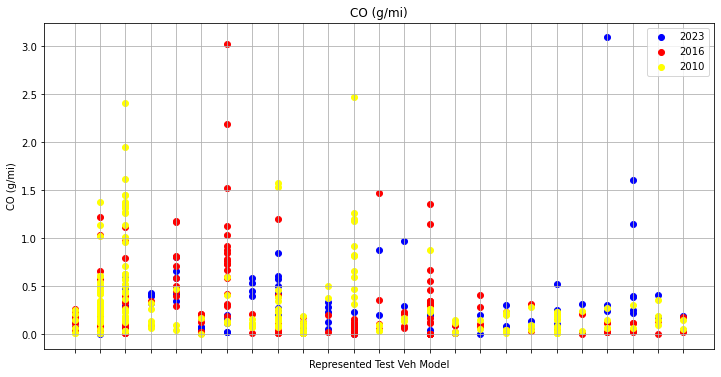

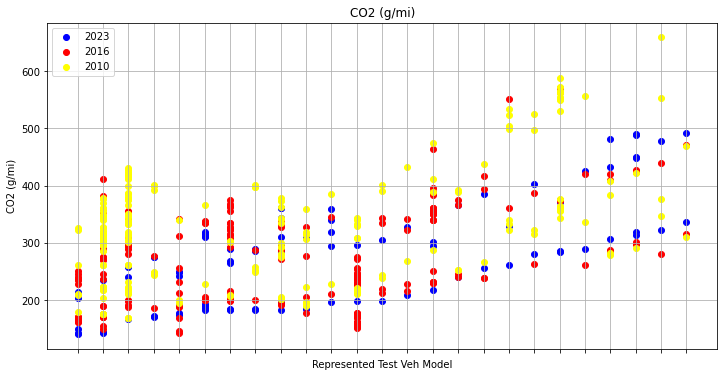

In [586]:
import matplotlib.pyplot as plt


# Create separate dataframes for CO and CO2
df_CO = selected_rows[['Represented Test Veh Model', 'Model Year', 'CO (g/mi)']]
df_CO2 = selected_rows[['Represented Test Veh Model', 'Model Year', 'CO2 (g/mi)']]

# Set up the figure and axes for CO plot
fig, ax1 = plt.subplots()
fig.set_size_inches(12, 6)
ax1.set_xlabel('Represented Test Veh Model')
ax1.set_ylabel('CO (g/mi)')
ax1.set_title('CO (g/mi)')

ax1.set_xticklabels([])

# Plot each year as scatter plot with a different color
for year, color in zip(df_CO['Model Year'].unique(), ['blue', 'red', 'yellow']):
    df_year = df_CO[df_CO['Model Year'] == year]
    ax1.scatter(df_year['Represented Test Veh Model'], df_year['CO (g/mi)'], color=color, label=year)

# Add legend and gridlines
ax1.legend()
ax1.grid()

# Set up the figure and axes for CO2 plot
fig, ax2 = plt.subplots()
fig.set_size_inches(12, 6)
ax2.set_xlabel('Represented Test Veh Model')
ax2.set_ylabel('CO2 (g/mi)')
ax2.set_title('CO2 (g/mi)')

ax2.set_xticklabels([])

# Plot each year as scatter plot with a different color
for year, color in zip(df_CO2['Model Year'].unique(), ['blue', 'red', 'yellow']):
    df_year = df_CO2[df_CO2['Model Year'] == year]
    ax2.scatter(df_year['Represented Test Veh Model'], df_year['CO2 (g/mi)'], color=color, label=year)

# Add legend and gridlines
ax2.legend()
ax2.grid()

# Show the plots
plt.show()


    We can see from above plot, for CO, there is an obvious decreasing of the same type of vehicle model from 2010 to 2016 and to 2023. 
    However, for CO2, there's just an obvious decreasing from 2010 to 2016. The relationship between 2016 to 2023 need to be verified in other ways.

#### So we're going to calculate the 'High' ratio for CO and CO2 in the 3 years seperately.

In [587]:
frequency1 = df.groupby('Model Year')['CO_binary'].mean()
frequency1

Model Year
2010    0.056846
2016    0.039153
2023    0.033626
Name: CO_binary, dtype: float64

In [588]:
frequency2 = df.groupby('Model Year')['CO2_binary'].mean()
frequency2

Model Year
2010    0.022877
2016    0.008372
2023    0.010234
Name: CO2_binary, dtype: float64

     As we can see from the frequency, the result is consistent from the plots. For for CO, there is an obvious decreasing of the same type of vehicle model from 2010 to 2016 and to 2023. 
    However, for CO2, there's just an obvious decreasing from 2010 to 2016. We cannot conclude yet that the CO2 pollution decreased from 2016 to 2023